### Advanced Lane Finding Project

Below are the necessary imports

In [ ]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import find_peaks_cwt
import glob
%matplotlib inline



#### Location of calibration images.

In [5]:

filenames = glob.glob('C:\\Users\\SHASHI RAWAT\\CarND-Advanced-Lane-Lines\\camera_cal\\calibration*.jpg')



C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration10.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration11.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration12.jpg


C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration13.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration14.jpg


C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration15.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration16.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration17.jpg


C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration18.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration19.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration2.jpg


C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration20.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration3.jpg


C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration6.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration7.jpg
C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration8.jpg


C:\Users\SHASHI RAWAT\CarND-Advanced-Lane-Lines\camera_cal\calibration9.jpg


Text(0.5,1,'Undistorted Image')

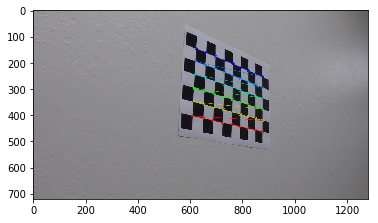

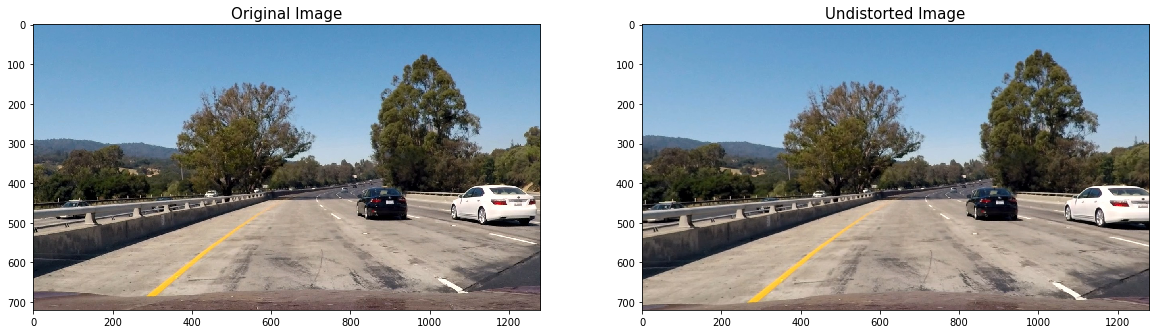

In [ ]:
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in filenames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        plt.imshow(img)

img = mpimg.imread(filenames[11])
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

img = plt.imread("C:\\Users\\SHASHI RAWAT\\CarND-Advanced-Lane-Lines\\test_images\\test1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)


In [9]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

print("Function for masking region of interest")

Function for masking region of interest


In [10]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

print("Functions for edge dections are created")

Functions for edge dections are created


image shape: (720, 1280, 3)
Warped function (Perspective) is created


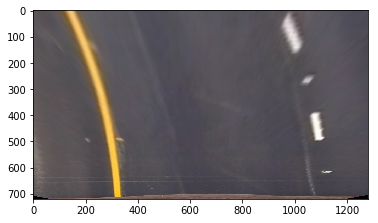

In [11]:
# Define image shape

road_images = glob.glob('C:\\Users\\SHASHI RAWAT\\CarND-Advanced-Lane-Lines\\test_images\\test*.jpg')
image = mpimg.imread(road_images[1])
image_shape = image.shape
print("image shape:",image_shape)
plt.imshow(image)

# Define the region
area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def perspective_warped(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Choose an offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

print("Warped function (Perspective) is created")
warped , M,Minv = perspective_warped(image,nx,ny,mtx,dist)
plt.imshow(warped)


In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values in windows
        self.windows = np.ones((3,12))*-1
        
print("Line class is defined")

Line class is defined


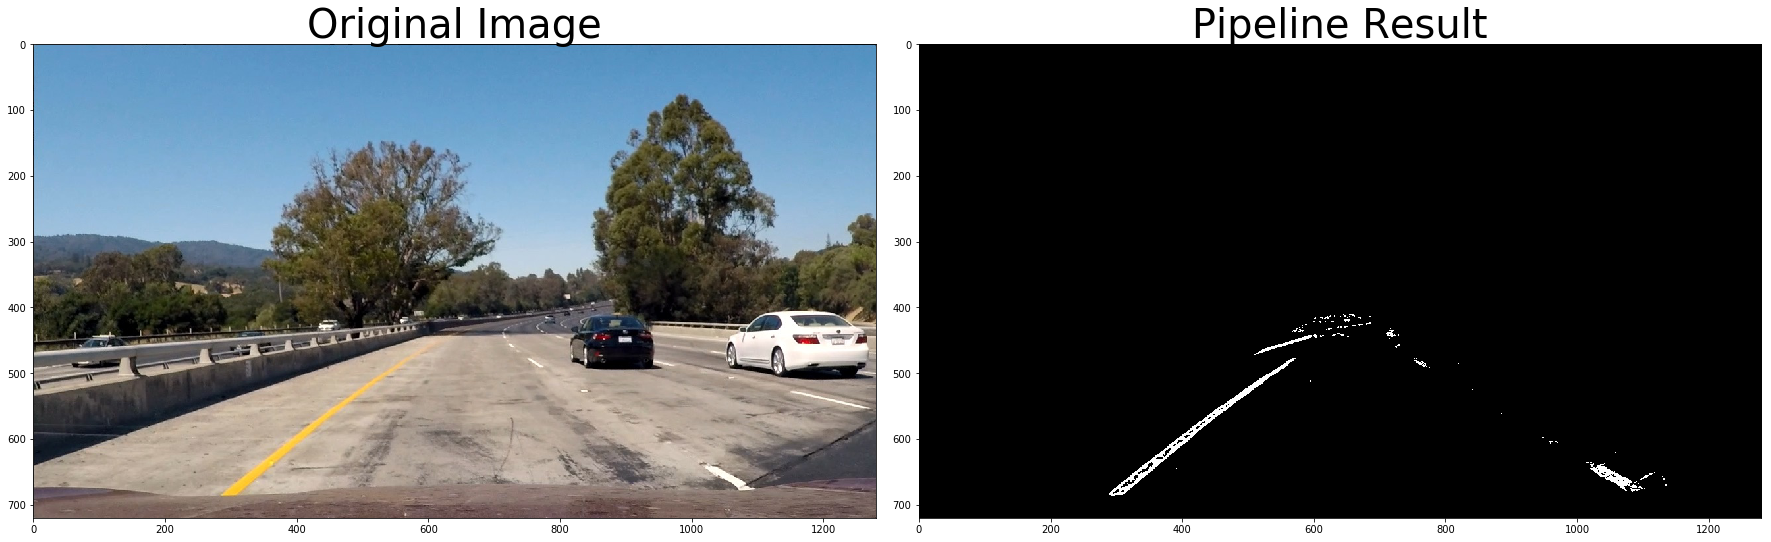

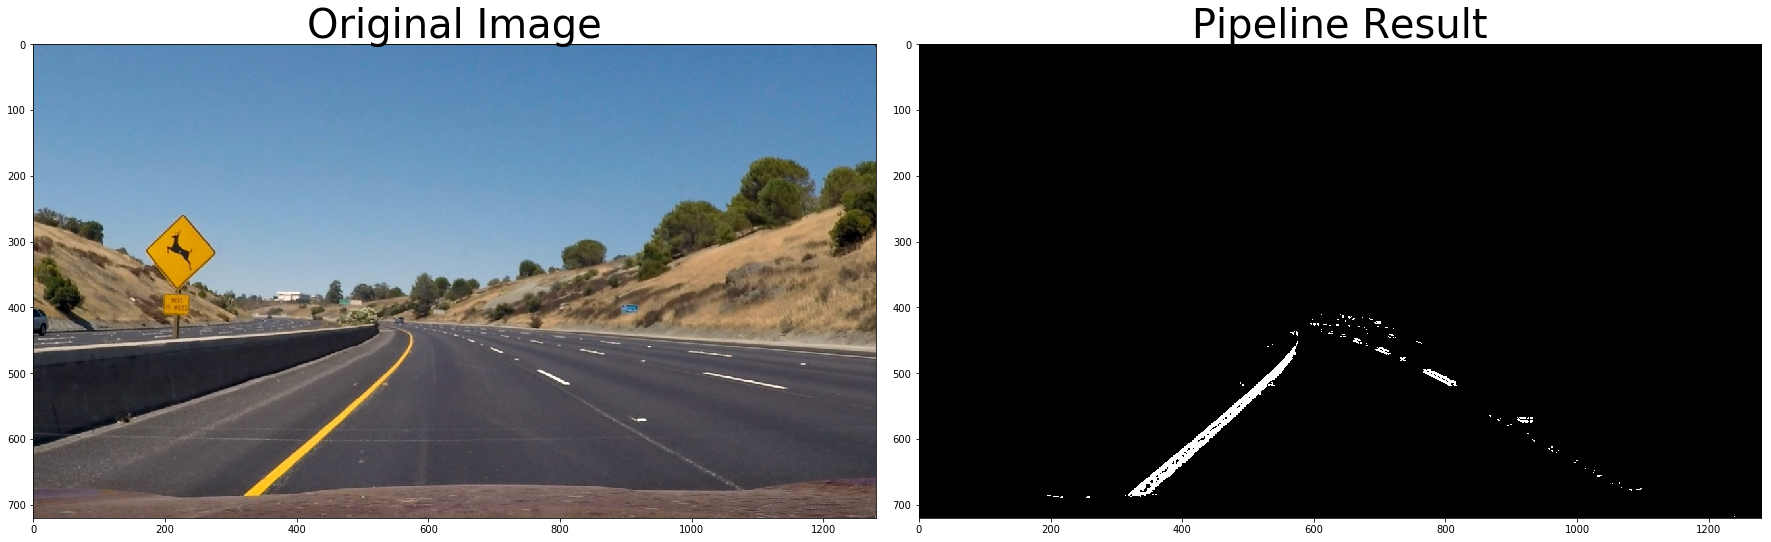

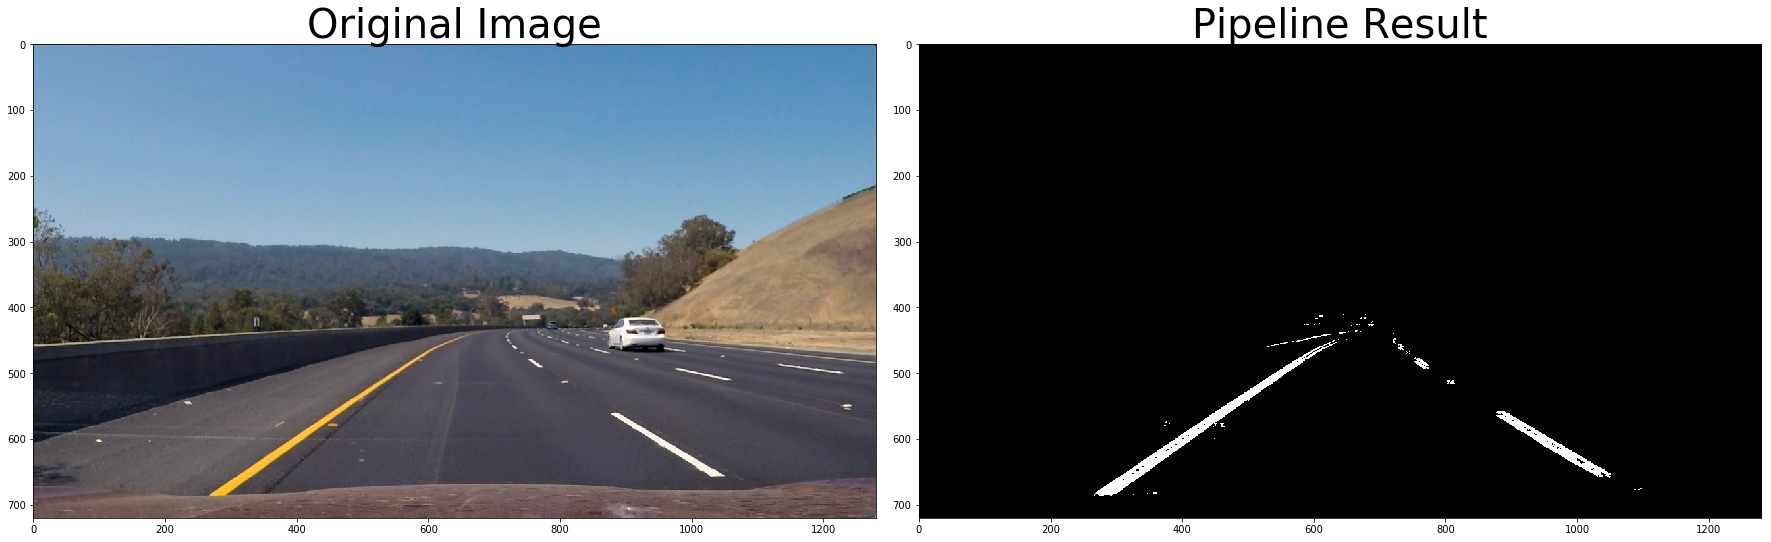

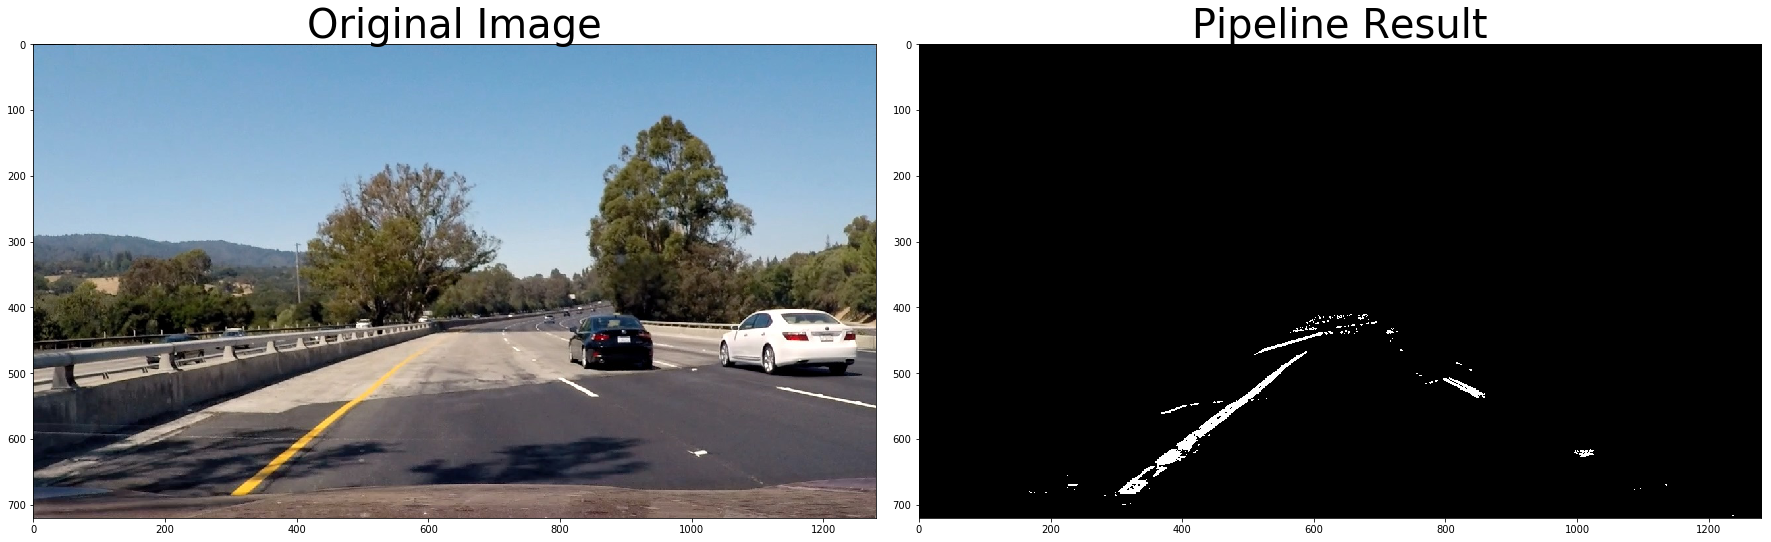

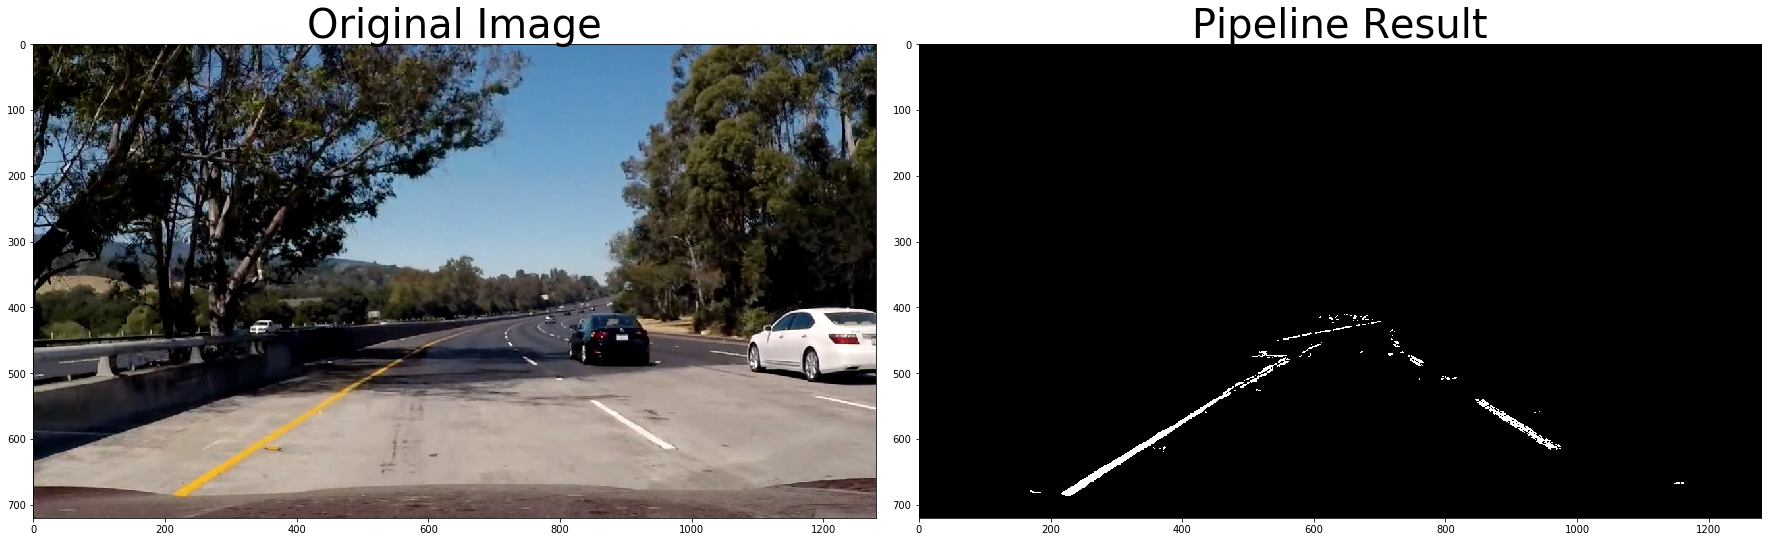

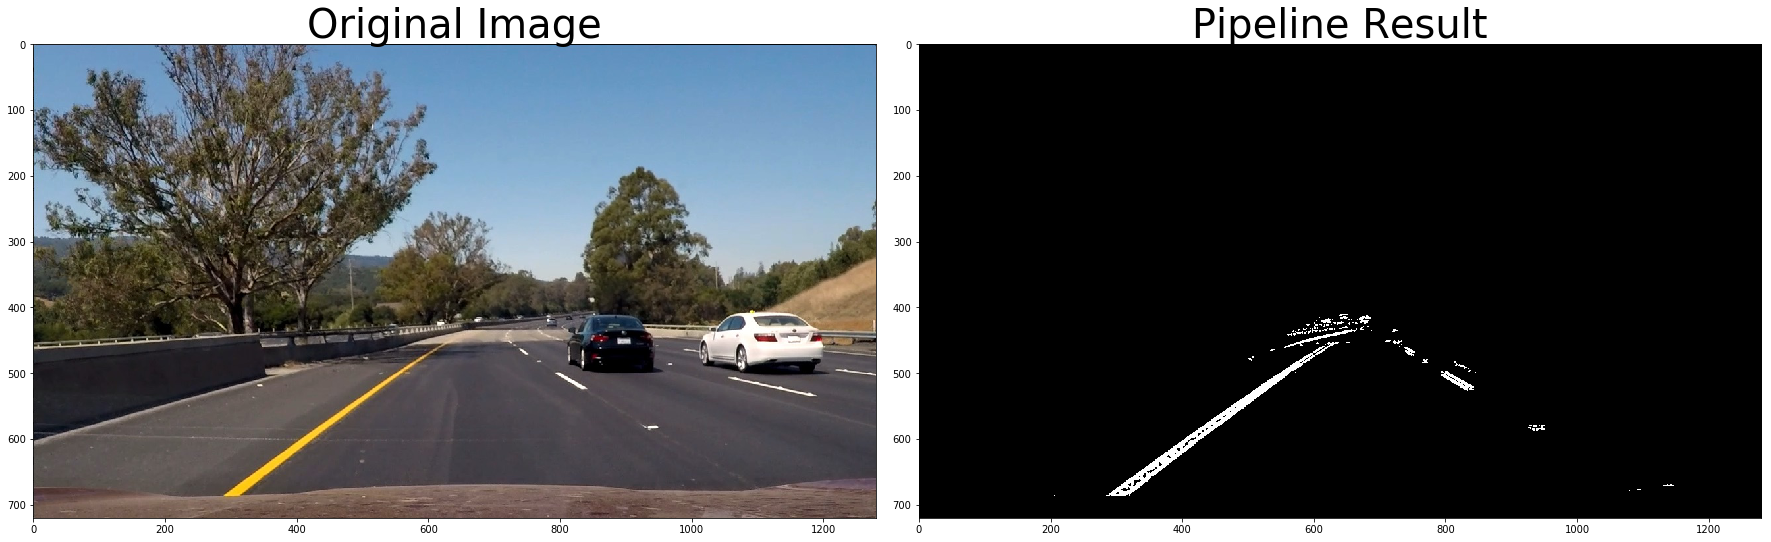

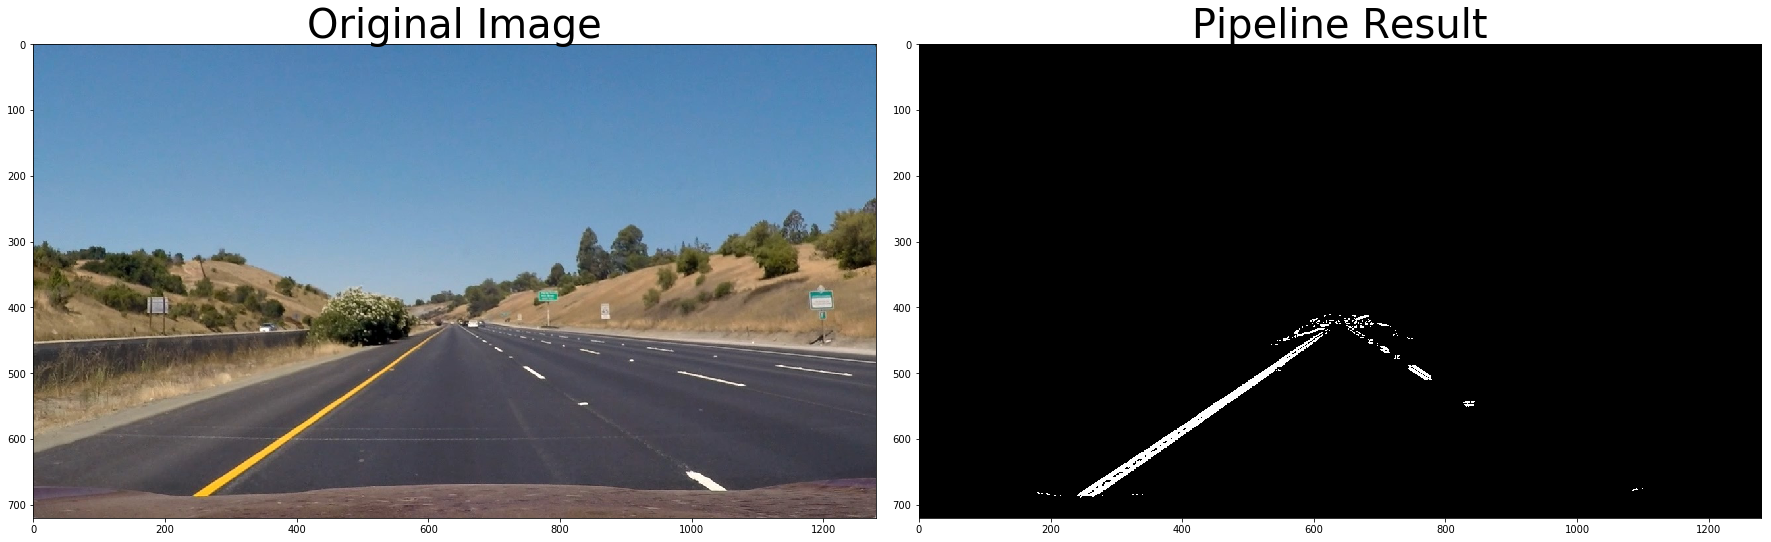

In [14]:
# Edit this function to create your own pipeline.
def pipeline(img):     
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary
    
for fname in road_images:
    image = mpimg.imread(fname)
    result = pipeline(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

In [16]:
def find_peaks(binary_warped):
    '''# Find the historgram from the image inside the window
    histogram = np.sum(image[y_window_top:y_window_bottom,:], axis=0)
    # Find the max from the histogram
    if len(histogram[int(x_left):int(x_right)])>0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2 '''
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base,rightx_base



In [17]:
def find_nearest(array,value):
    # Function to find the nearest point from array
    if len(array) > 0:
        idx = (np.abs(array-value)).argmin()
        return array[idx]


In [18]:
def sanity_check(lane,curverad,fitx,fit):
    if lane.detected:
        # If sane result
        if abs(curverad/lane.radius_of_curvature -1)<1:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
        # If not a sane result
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        #If lane was not detected and no radius
        if lane.radius_of_curvature:
            if abs(curverad/lane.radius_of_curvature -1)<1:
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
        # If not a sane result
            else:
                lane.detected = False
                fitx = lane.allx
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx
    


In [19]:
def find_lanes(n_windows,binary_warped,leftx_base,rightx_base):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nwindows = n_windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return leftx, lefty, rightx, righty

In [20]:
def fit_lanes(n_windows,binary_warped,leftx=None,lefty=None, rightx=None, righty=None):
    yvals = np.linspace(0, 719, num=720)
    if leftx==None:
        leftx_base,rightx_base = find_peaks(binary_warped)
        leftx, lefty, rightx, righty = find_lanes(n_windows,binary_warped,leftx_base,rightx_base)
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_curverad  = find_curvature(yvals, left_fitx)
        right_curverad = find_curvature(yvals, right_fitx)
        curvature = (left_curverad+right_curverad)/2 
        return yvals,left_fitx,right_fitx,curvature
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_curverad  = find_curvature(yvals, left_fitx)
        right_curverad = find_curvature(yvals, right_fitx)
        curvature = (left_curverad+right_curverad)/2 
        
        return yvals,left_fitx,right_fitx,curvature 
print("Fit_lanes are done")

Fit_lanes are done


In [21]:
# draw poly on an image
# def draw_poly(image, warped, yvals, left_fitx, right_fitx, Minv):
def draw_poly(image, warped, yvals, left_fitx, right_fitx, 
              Minv, curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result

print("Draw poly on a original image")

Draw poly on a original image


In [22]:
# This function will color the image
# Input: Original image
# Output: Original image with colored region
def process_image(image):
    # Apply pipeline to the image to create black and white image
    img = pipeline(image)
    n_windows = 9
    # Warp the image to make lanes parallel to each other
    top_down, perspective_M, perspective_Minv = perspective_warped(img, nx, ny, mtx, dist)
    # Find the lines fitting to left and right lanes
    a, b, c, curvature = fit_lanes(n_windows,top_down)
    # Return the original image with colored region
    return draw_poly(image, top_down, a, b, c, perspective_Minv, curvature)


F:\Miniconda\envs\general_1\lib\site-packages\scipy\signal\_peak_finding.py:1113: RuntimeWarning: divide by zero encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


F:\Miniconda\envs\general_1\lib\site-packages\scipy\signal\_peak_finding.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  snr = abs(cwt[line[0][0], line[1][0]] / noises[line[1][0]])


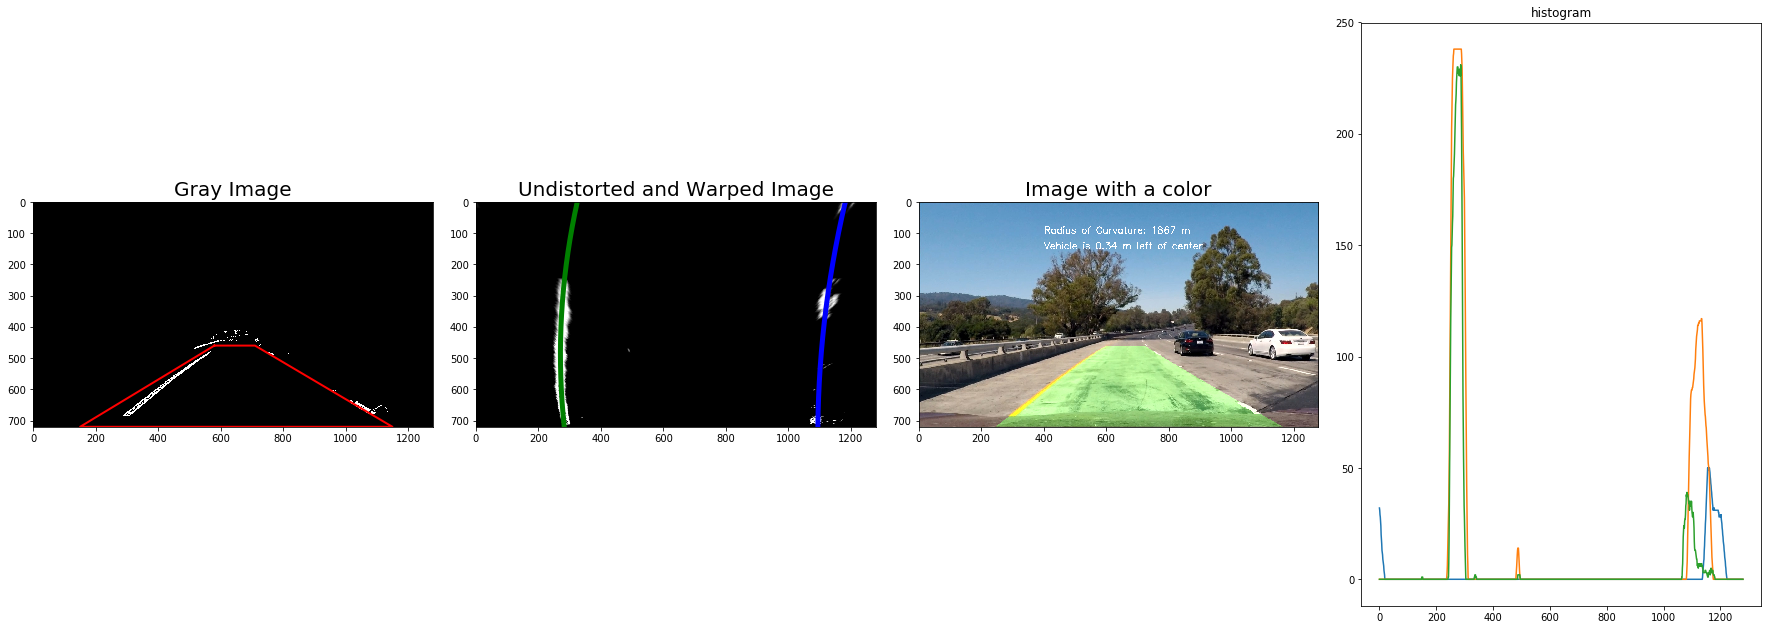

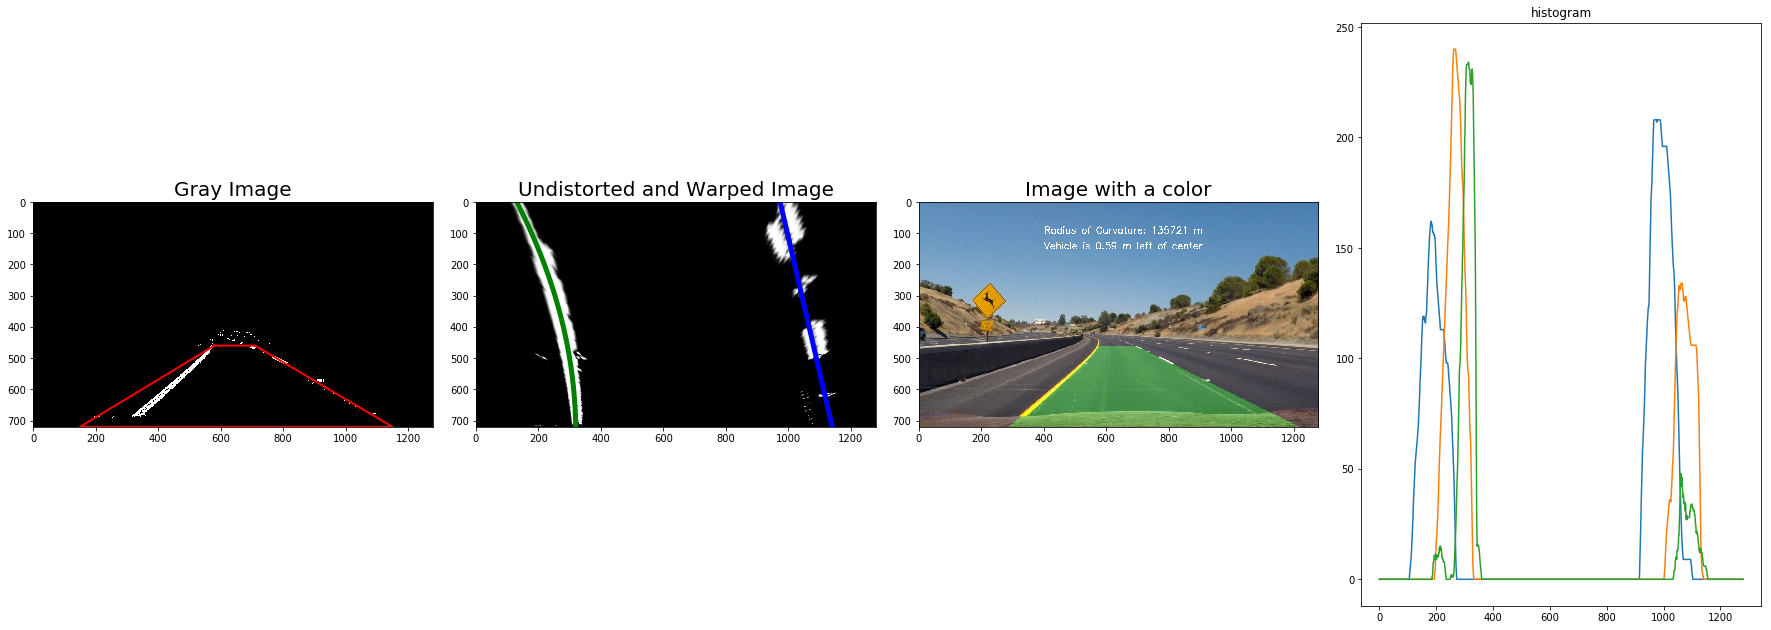

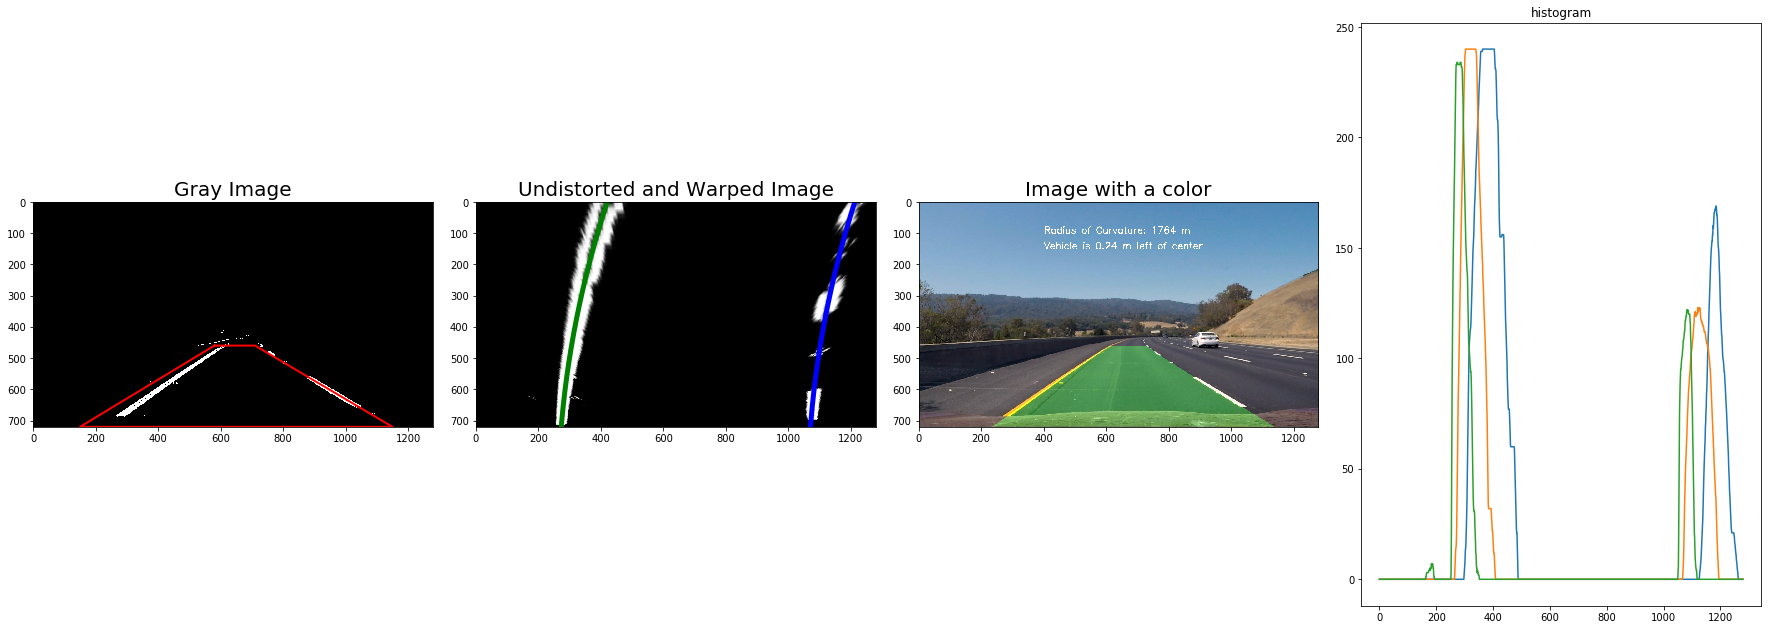

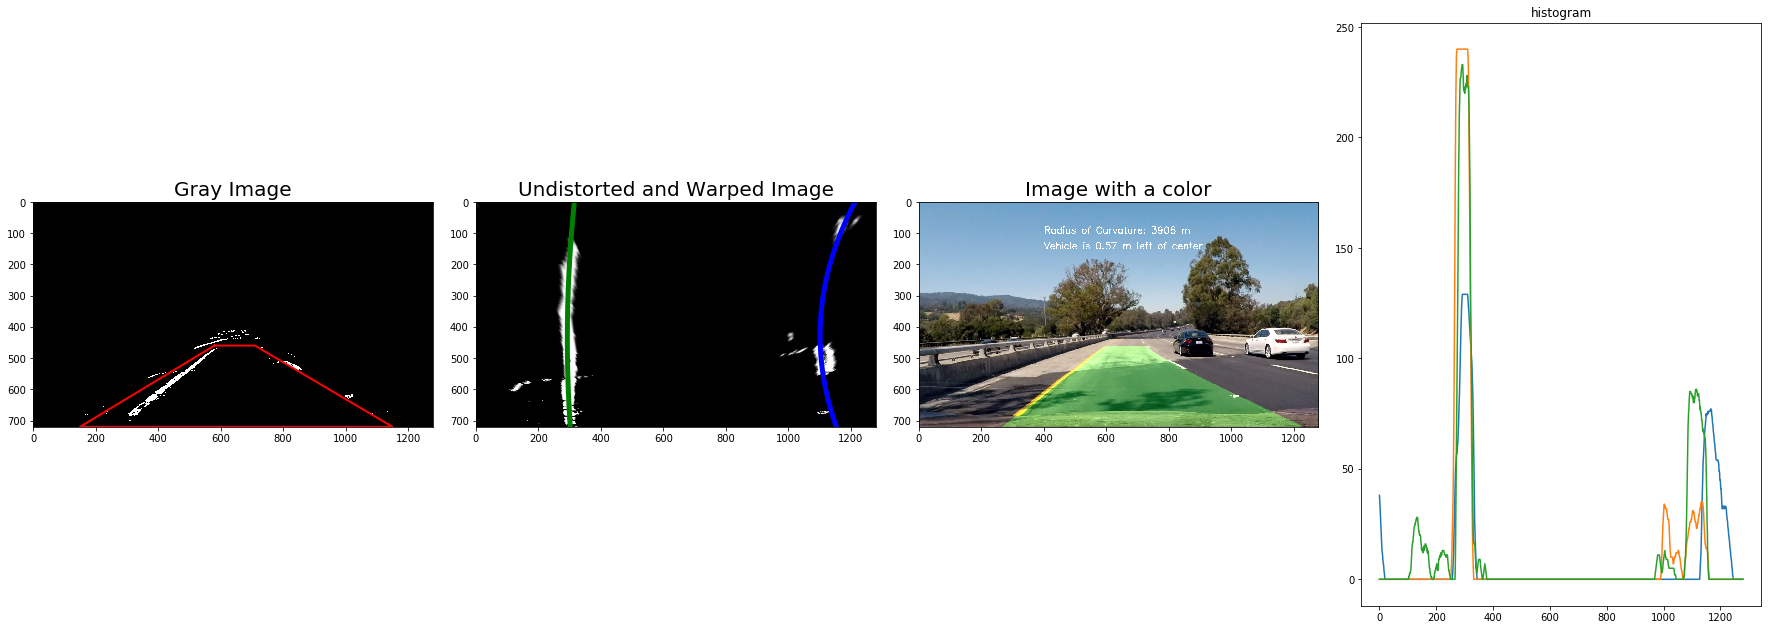

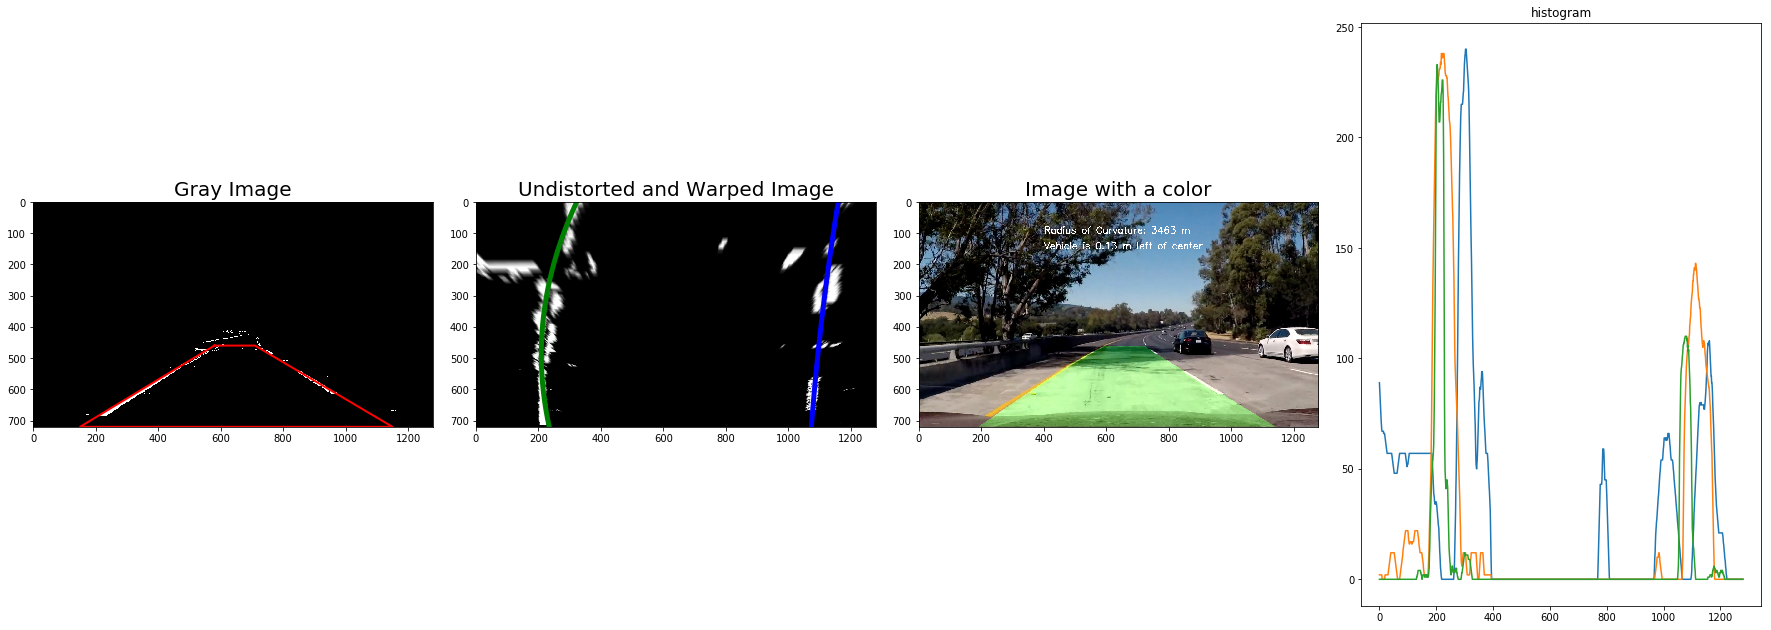

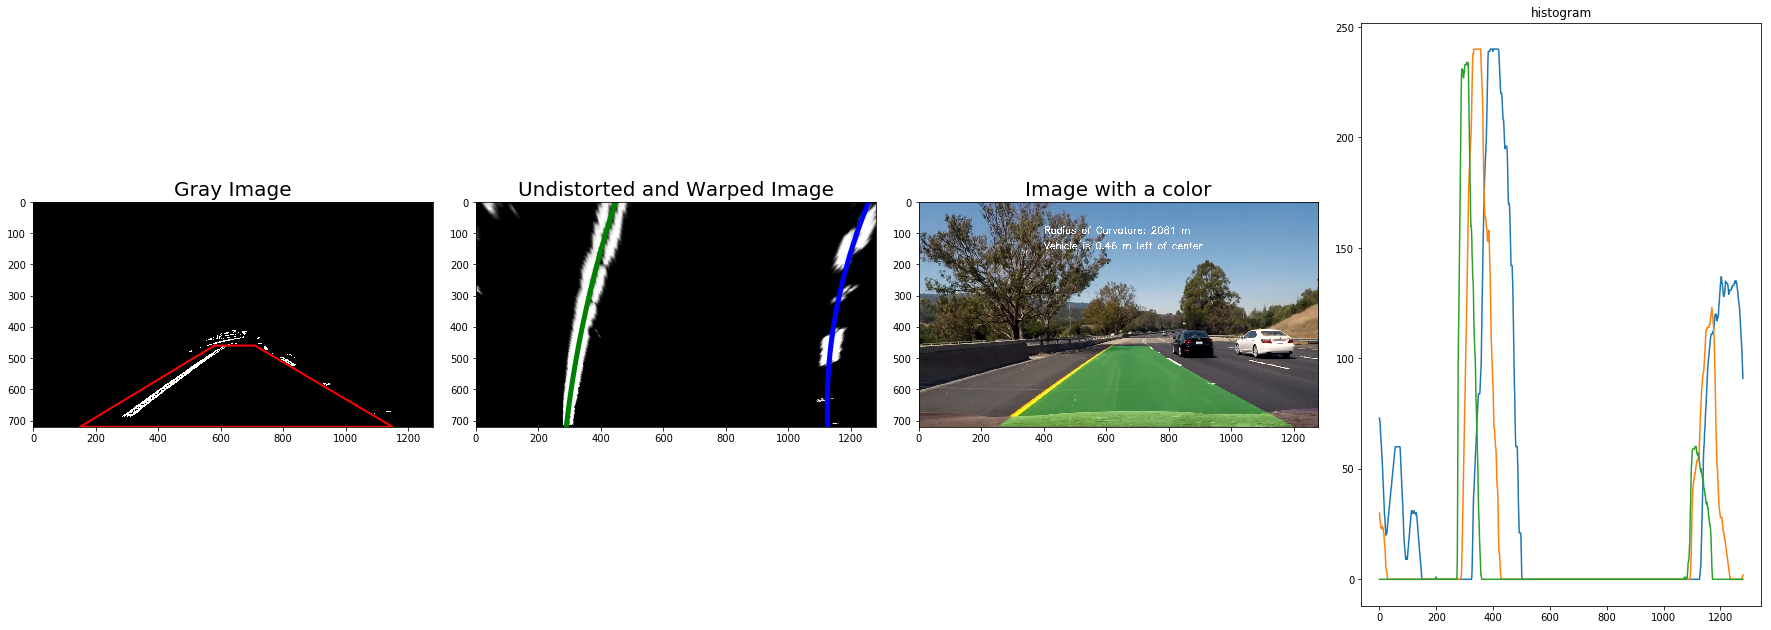

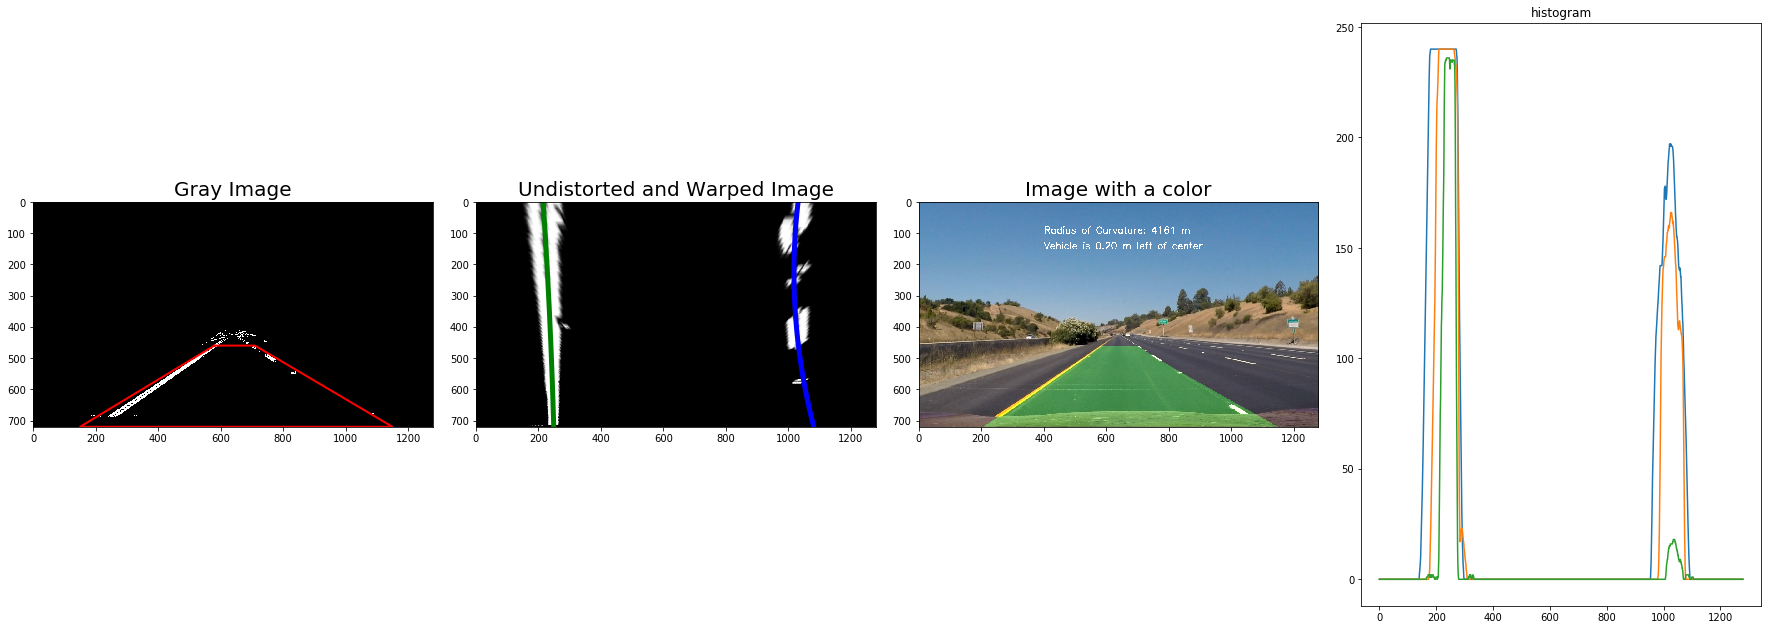

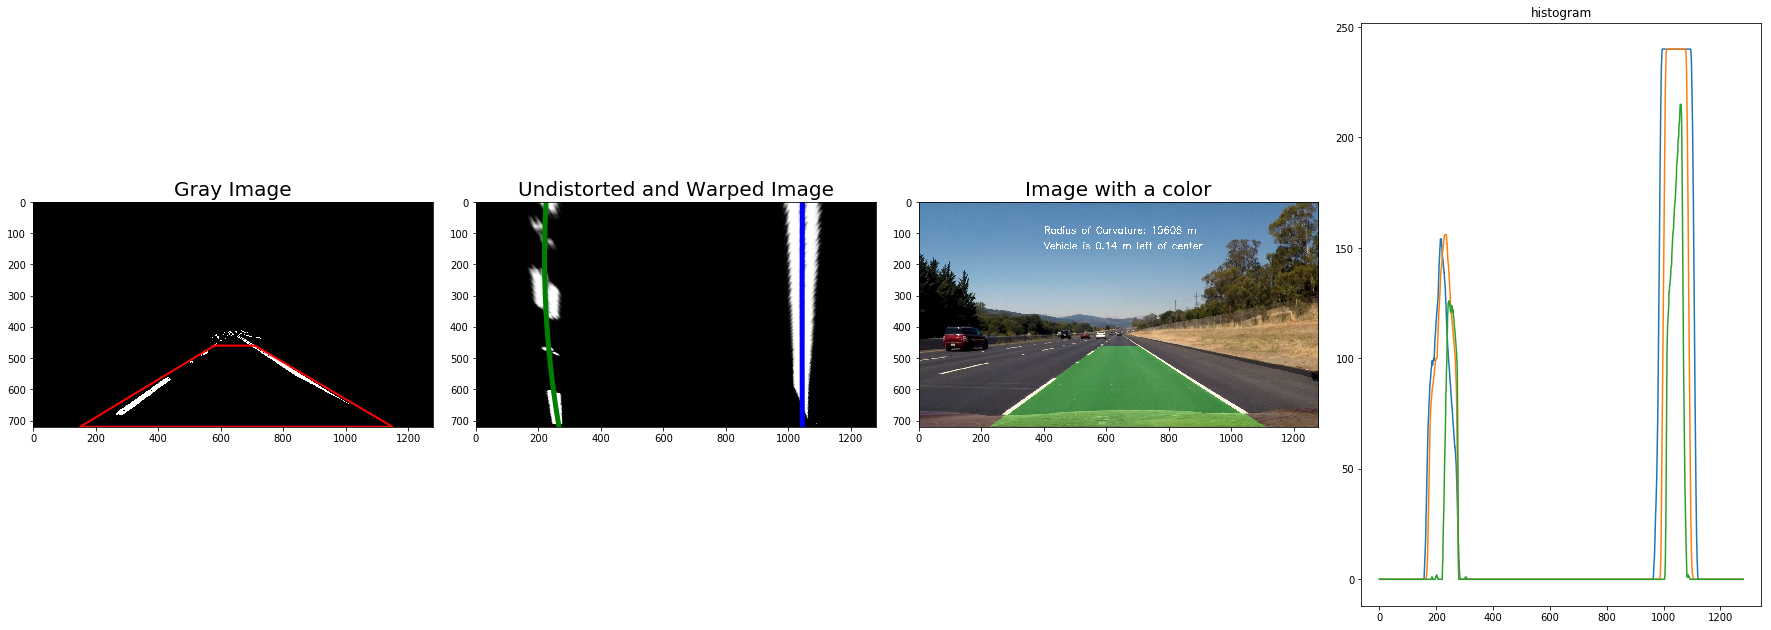

In [23]:
# These are to be used to plot lines on images
x_values = [area_of_interest[0][0],area_of_interest[1][0],area_of_interest[2][0],area_of_interest[3][0],area_of_interest[0][0]]
y_values = [area_of_interest[0][1],area_of_interest[1][1],area_of_interest[2][1],area_of_interest[3][1],area_of_interest[0][1]]

# Plot 6 example images and warp them

for fname in road_images:
    # load the image
    img_raw = mpimg.imread(fname)
    # Set up lines for left and right
    left_lane = Line()
    right_lane = Line()
    # Apply pipeline to the image to create black and white image
    img = pipeline(img_raw)
    # Unwrap the image
    top_down, perspective_M, perspective_Minv = perspective_warped(img, nx, ny, mtx, dist)
    # Set up for the subplots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    # Showing the image from pipeline with marked areas
    ax1.set_title('Gray Image', fontsize=20)
    ax1.plot(x_values,y_values,'r-',lw=2)
    ax1.imshow(img, cmap='gray')
    # Find lanes from the warped image
    a, b, c,curvature = fit_lanes(9,top_down)
    ax2.plot(b, a, color='green', linewidth=5)
    ax2.plot(c, a, color='blue', linewidth=5)
    ax2.imshow(top_down, cmap='gray')
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    # Set up lines for left and right
    left_lane = Line()
    right_lane = Line()    
    # Use the information from fit_lane function to color the lanes
    image_color = process_image(img_raw)
    ax3.imshow(image_color)
    ax3.set_title('Image with a color', fontsize=20)
    # Plot three histograms
    top_down[top_down > 0] = 1
    histogram = np.sum(top_down[:240,:], axis=0)
    ax4.plot(histogram)
    histogram = np.sum(top_down[240:480,:], axis=0)
    ax4.plot(histogram)
    histogram = np.sum(top_down[480:,:], axis=0)
    ax4.plot(histogram)
    indexes = find_peaks_cwt(histogram, np.arange(1, 550))
    ax4.set_title("histogram")
    # Adjusting subplots
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [25]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = 'white1.mp4'
clip1 = VideoFileClip("C:\\Users\\SHASHI RAWAT\\CarND-Advanced-Lane-Lines\\project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white1.mp4


[MoviePy] Writing video white1.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<11:51,  1.77it/s]

  0%|          | 2/1261 [00:01<17:14,  1.22it/s]

  0%|          | 3/1261 [00:02<15:50,  1.32it/s]

  0%|          | 4/1261 [00:02<14:43,  1.42it/s]

  0%|          | 5/1261 [00:03<13:59,  1.50it/s]

  0%|          | 6/1261 [00:03<13:37,  1.54it/s]

  1%|          | 7/1261 [00:04<13:13,  1.58it/s]

  1%|          | 8/1261 [00:04<12:59,  1.61it/s]

  1%|          | 9/1261 [00:05<12:34,  1.66it/s]

  1%|          | 10/1261 [00:05<12:12,  1.71it/s]

  1%|          | 11/1261 [00:06<11:54,  1.75it/s]

  1%|          | 12/1261 [00:06<11:49,  1.76it/s]

  1%|          | 13/1261 [00:07<11:35,  1.80it/s]

  1%|          | 14/1261 [00:07<11:21,  1.83it/s]

  1%|          | 15/1261 [00:08<11:07,  1.87it/s]

  1%|▏         | 16/1261 [00:08<10:57,  1.89it/s]

  1%|▏         | 17/1261 [00:08<10:47,  1.92it/s]

  1%|▏         | 18/1261 [00:09<10:40,  1.94it/s]

  2%|▏         | 19/1261 [00:09<10:32,  1.96it/s]

  2%|▏         | 20/1261 [00:10<10:25,  1.98it/s]

  2%|▏         | 21/1261 [00:10<10:19,  2.00it/s]

  2%|▏         | 22/1261 [00:10<10:12,  2.02it/s]

  2%|▏         | 23/1261 [00:11<10:07,  2.04it/s]

  2%|▏         | 24/1261 [00:11<10:02,  2.05it/s]

  2%|▏         | 25/1261 [00:12<09:58,  2.07it/s]

  2%|▏         | 26/1261 [00:12<09:53,  2.08it/s]

  2%|▏         | 27/1261 [00:12<09:49,  2.09it/s]

  2%|▏         | 28/1261 [00:13<09:45,  2.10it/s]

  2%|▏         | 29/1261 [00:13<09:42,  2.12it/s]

  2%|▏         | 30/1261 [00:14<09:38,  2.13it/s]

  2%|▏         | 31/1261 [00:14<09:35,  2.14it/s]

  3%|▎         | 32/1261 [00:14<09:32,  2.15it/s]

  3%|▎         | 33/1261 [00:15<09:29,  2.16it/s]

  3%|▎         | 34/1261 [00:15<09:26,  2.16it/s]

  3%|▎         | 35/1261 [00:16<09:23,  2.17it/s]

  3%|▎         | 36/1261 [00:16<09:21,  2.18it/s]

  3%|▎         | 37/1261 [00:16<09:18,  2.19it/s]

  3%|▎         | 38/1261 [00:17<09:17,  2.19it/s]

  3%|▎         | 39/1261 [00:17<09:15,  2.20it/s]

  3%|▎         | 40/1261 [00:18<09:12,  2.21it/s]

  3%|▎         | 41/1261 [00:18<09:11,  2.21it/s]

  3%|▎         | 42/1261 [00:18<09:09,  2.22it/s]

  3%|▎         | 43/1261 [00:19<09:10,  2.21it/s]

  3%|▎         | 44/1261 [00:19<09:08,  2.22it/s]

  4%|▎         | 45/1261 [00:20<09:06,  2.22it/s]

  4%|▎         | 46/1261 [00:20<09:05,  2.23it/s]

  4%|▎         | 47/1261 [00:21<09:04,  2.23it/s]

  4%|▍         | 48/1261 [00:21<09:03,  2.23it/s]

  4%|▍         | 49/1261 [00:21<09:02,  2.23it/s]

  4%|▍         | 50/1261 [00:22<09:01,  2.24it/s]

  4%|▍         | 51/1261 [00:22<09:00,  2.24it/s]

  4%|▍         | 52/1261 [00:23<09:00,  2.24it/s]

  4%|▍         | 53/1261 [00:23<08:59,  2.24it/s]

  4%|▍         | 54/1261 [00:24<08:57,  2.24it/s]

  4%|▍         | 55/1261 [00:24<08:56,  2.25it/s]

  4%|▍         | 56/1261 [00:24<08:56,  2.25it/s]

  5%|▍         | 57/1261 [00:25<08:55,  2.25it/s]

  5%|▍         | 58/1261 [00:25<08:54,  2.25it/s]

  5%|▍         | 59/1261 [00:26<08:53,  2.25it/s]

  5%|▍         | 60/1261 [00:26<08:53,  2.25it/s]

  5%|▍         | 61/1261 [00:27<08:52,  2.25it/s]

  5%|▍         | 62/1261 [00:27<08:51,  2.26it/s]

  5%|▍         | 63/1261 [00:27<08:50,  2.26it/s]

  5%|▌         | 64/1261 [00:28<08:50,  2.26it/s]

  5%|▌         | 65/1261 [00:28<08:49,  2.26it/s]

  5%|▌         | 66/1261 [00:29<08:48,  2.26it/s]

  5%|▌         | 67/1261 [00:29<08:48,  2.26it/s]

  5%|▌         | 68/1261 [00:30<08:47,  2.26it/s]

  5%|▌         | 69/1261 [00:30<08:46,  2.26it/s]

  6%|▌         | 70/1261 [00:30<08:45,  2.26it/s]

  6%|▌         | 71/1261 [00:31<08:45,  2.26it/s]

  6%|▌         | 72/1261 [00:31<08:44,  2.27it/s]

  6%|▌         | 73/1261 [00:32<08:44,  2.27it/s]

  6%|▌         | 74/1261 [00:32<08:43,  2.27it/s]

  6%|▌         | 75/1261 [00:33<08:42,  2.27it/s]

  6%|▌         | 76/1261 [00:33<08:41,  2.27it/s]

  6%|▌         | 77/1261 [00:33<08:41,  2.27it/s]

  6%|▌         | 78/1261 [00:34<08:40,  2.27it/s]

  6%|▋         | 79/1261 [00:34<08:40,  2.27it/s]

  6%|▋         | 80/1261 [00:35<08:39,  2.27it/s]

  6%|▋         | 81/1261 [00:35<08:38,  2.27it/s]

  7%|▋         | 82/1261 [00:36<08:37,  2.28it/s]

  7%|▋         | 83/1261 [00:36<08:37,  2.28it/s]

  7%|▋         | 84/1261 [00:36<08:37,  2.28it/s]

  7%|▋         | 85/1261 [00:37<08:36,  2.28it/s]

  7%|▋         | 86/1261 [00:37<08:35,  2.28it/s]

  7%|▋         | 87/1261 [00:38<08:34,  2.28it/s]

  7%|▋         | 88/1261 [00:38<08:34,  2.28it/s]

  7%|▋         | 89/1261 [00:38<08:33,  2.28it/s]

  7%|▋         | 90/1261 [00:39<08:32,  2.28it/s]

  7%|▋         | 91/1261 [00:39<08:32,  2.28it/s]

  7%|▋         | 92/1261 [00:40<08:31,  2.28it/s]

  7%|▋         | 93/1261 [00:40<08:31,  2.29it/s]

  7%|▋         | 94/1261 [00:41<08:30,  2.29it/s]

  8%|▊         | 95/1261 [00:41<08:30,  2.29it/s]

  8%|▊         | 96/1261 [00:41<08:29,  2.29it/s]

  8%|▊         | 97/1261 [00:42<08:28,  2.29it/s]

  8%|▊         | 98/1261 [00:42<08:28,  2.29it/s]

  8%|▊         | 99/1261 [00:43<08:27,  2.29it/s]

  8%|▊         | 100/1261 [00:43<08:28,  2.28it/s]

  8%|▊         | 101/1261 [00:44<08:29,  2.28it/s]

  8%|▊         | 102/1261 [00:44<08:28,  2.28it/s]

  8%|▊         | 103/1261 [00:45<08:28,  2.28it/s]

  8%|▊         | 104/1261 [00:45<08:27,  2.28it/s]

  8%|▊         | 105/1261 [00:46<08:26,  2.28it/s]

  8%|▊         | 106/1261 [00:46<08:26,  2.28it/s]

  8%|▊         | 107/1261 [00:46<08:25,  2.28it/s]

  9%|▊         | 108/1261 [00:47<08:25,  2.28it/s]

  9%|▊         | 109/1261 [00:47<08:24,  2.28it/s]

  9%|▊         | 110/1261 [00:48<08:24,  2.28it/s]

  9%|▉         | 111/1261 [00:48<08:23,  2.28it/s]

  9%|▉         | 112/1261 [00:49<08:22,  2.29it/s]

  9%|▉         | 113/1261 [00:49<08:22,  2.29it/s]

  9%|▉         | 114/1261 [00:49<08:21,  2.29it/s]

  9%|▉         | 115/1261 [00:50<08:21,  2.29it/s]

  9%|▉         | 116/1261 [00:50<08:20,  2.29it/s]

  9%|▉         | 117/1261 [00:51<08:20,  2.29it/s]

  9%|▉         | 118/1261 [00:51<08:19,  2.29it/s]

  9%|▉         | 119/1261 [00:51<08:18,  2.29it/s]

 10%|▉         | 120/1261 [00:52<08:18,  2.29it/s]

 10%|▉         | 121/1261 [00:52<08:18,  2.29it/s]

 10%|▉         | 122/1261 [00:53<08:17,  2.29it/s]

 10%|▉         | 123/1261 [00:53<08:16,  2.29it/s]

 10%|▉         | 124/1261 [00:54<08:16,  2.29it/s]

 10%|▉         | 125/1261 [00:54<08:15,  2.29it/s]

 10%|▉         | 126/1261 [00:54<08:15,  2.29it/s]

 10%|█         | 127/1261 [00:55<08:15,  2.29it/s]

 10%|█         | 128/1261 [00:55<08:15,  2.29it/s]

 10%|█         | 129/1261 [00:56<08:14,  2.29it/s]

 10%|█         | 130/1261 [00:56<08:14,  2.29it/s]

 10%|█         | 131/1261 [00:57<08:14,  2.28it/s]

 10%|█         | 132/1261 [00:57<08:14,  2.28it/s]

 11%|█         | 133/1261 [00:58<08:14,  2.28it/s]

 11%|█         | 134/1261 [00:58<08:14,  2.28it/s]

 11%|█         | 135/1261 [00:59<08:14,  2.28it/s]

 11%|█         | 136/1261 [00:59<08:15,  2.27it/s]

 11%|█         | 137/1261 [01:00<08:15,  2.27it/s]

 11%|█         | 138/1261 [01:00<08:15,  2.27it/s]

 11%|█         | 139/1261 [01:01<08:15,  2.26it/s]

 11%|█         | 140/1261 [01:02<08:16,  2.26it/s]

 11%|█         | 141/1261 [01:02<08:16,  2.25it/s]

 11%|█▏        | 142/1261 [01:02<08:16,  2.25it/s]

 11%|█▏        | 143/1261 [01:03<08:16,  2.25it/s]

 11%|█▏        | 144/1261 [01:03<08:15,  2.25it/s]

 11%|█▏        | 145/1261 [01:04<08:15,  2.25it/s]

 12%|█▏        | 146/1261 [01:04<08:15,  2.25it/s]

 12%|█▏        | 147/1261 [01:05<08:15,  2.25it/s]

 12%|█▏        | 148/1261 [01:05<08:15,  2.25it/s]

 12%|█▏        | 149/1261 [01:06<08:15,  2.25it/s]

 12%|█▏        | 150/1261 [01:06<08:14,  2.24it/s]

 12%|█▏        | 151/1261 [01:07<08:15,  2.24it/s]

 12%|█▏        | 152/1261 [01:07<08:15,  2.24it/s]

 12%|█▏        | 153/1261 [01:08<08:16,  2.23it/s]

 12%|█▏        | 154/1261 [01:09<08:17,  2.22it/s]

 12%|█▏        | 155/1261 [01:09<08:18,  2.22it/s]

 12%|█▏        | 156/1261 [01:10<08:18,  2.22it/s]

 12%|█▏        | 157/1261 [01:11<08:20,  2.21it/s]

 13%|█▎        | 158/1261 [01:11<08:20,  2.20it/s]

 13%|█▎        | 159/1261 [01:12<08:21,  2.20it/s]

 13%|█▎        | 160/1261 [01:12<08:21,  2.19it/s]

 13%|█▎        | 161/1261 [01:13<08:21,  2.19it/s]

 13%|█▎        | 162/1261 [01:13<08:21,  2.19it/s]

 13%|█▎        | 163/1261 [01:14<08:21,  2.19it/s]

 13%|█▎        | 164/1261 [01:15<08:22,  2.18it/s]

 13%|█▎        | 165/1261 [01:15<08:22,  2.18it/s]

 13%|█▎        | 166/1261 [01:16<08:22,  2.18it/s]

 13%|█▎        | 167/1261 [01:16<08:21,  2.18it/s]

 13%|█▎        | 168/1261 [01:17<08:21,  2.18it/s]

 13%|█▎        | 169/1261 [01:17<08:21,  2.18it/s]

 13%|█▎        | 170/1261 [01:18<08:21,  2.18it/s]

 14%|█▎        | 171/1261 [01:18<08:21,  2.17it/s]

 14%|█▎        | 172/1261 [01:19<08:21,  2.17it/s]

 14%|█▎        | 173/1261 [01:19<08:21,  2.17it/s]

 14%|█▍        | 174/1261 [01:20<08:21,  2.17it/s]

 14%|█▍        | 175/1261 [01:21<08:23,  2.16it/s]

 14%|█▍        | 176/1261 [01:21<08:23,  2.16it/s]

 14%|█▍        | 177/1261 [01:22<08:23,  2.15it/s]

 14%|█▍        | 178/1261 [01:22<08:23,  2.15it/s]

 14%|█▍        | 179/1261 [01:23<08:23,  2.15it/s]

 14%|█▍        | 180/1261 [01:23<08:23,  2.15it/s]

 14%|█▍        | 181/1261 [01:24<08:23,  2.14it/s]

 14%|█▍        | 182/1261 [01:24<08:23,  2.14it/s]

 15%|█▍        | 183/1261 [01:25<08:23,  2.14it/s]

 15%|█▍        | 184/1261 [01:26<08:23,  2.14it/s]

 15%|█▍        | 185/1261 [01:26<08:24,  2.13it/s]

 15%|█▍        | 186/1261 [01:27<08:24,  2.13it/s]

 15%|█▍        | 187/1261 [01:28<08:26,  2.12it/s]

 15%|█▍        | 188/1261 [01:28<08:26,  2.12it/s]

 15%|█▍        | 189/1261 [01:29<08:27,  2.11it/s]

 15%|█▌        | 190/1261 [01:30<08:27,  2.11it/s]

 15%|█▌        | 191/1261 [01:30<08:27,  2.11it/s]

 15%|█▌        | 192/1261 [01:31<08:28,  2.10it/s]

 15%|█▌        | 193/1261 [01:31<08:28,  2.10it/s]

 15%|█▌        | 194/1261 [01:32<08:27,  2.10it/s]

 15%|█▌        | 195/1261 [01:32<08:27,  2.10it/s]

 16%|█▌        | 196/1261 [01:33<08:26,  2.10it/s]

 16%|█▌        | 197/1261 [01:33<08:25,  2.10it/s]

 16%|█▌        | 198/1261 [01:34<08:24,  2.11it/s]

 16%|█▌        | 199/1261 [01:34<08:24,  2.11it/s]

 16%|█▌        | 200/1261 [01:34<08:23,  2.11it/s]

 16%|█▌        | 201/1261 [01:35<08:22,  2.11it/s]

 16%|█▌        | 202/1261 [01:35<08:21,  2.11it/s]

 16%|█▌        | 203/1261 [01:36<08:21,  2.11it/s]

 16%|█▌        | 204/1261 [01:36<08:20,  2.11it/s]

 16%|█▋        | 205/1261 [01:37<08:19,  2.11it/s]

 16%|█▋        | 206/1261 [01:37<08:19,  2.11it/s]

 16%|█▋        | 207/1261 [01:38<08:19,  2.11it/s]

 16%|█▋        | 208/1261 [01:38<08:19,  2.11it/s]

 17%|█▋        | 209/1261 [01:39<08:19,  2.11it/s]

 17%|█▋        | 210/1261 [01:39<08:18,  2.11it/s]

 17%|█▋        | 211/1261 [01:40<08:18,  2.11it/s]

 17%|█▋        | 212/1261 [01:40<08:17,  2.11it/s]

 17%|█▋        | 213/1261 [01:41<08:17,  2.10it/s]

 17%|█▋        | 214/1261 [01:41<08:17,  2.10it/s]

 17%|█▋        | 215/1261 [01:42<08:17,  2.10it/s]

 17%|█▋        | 216/1261 [01:42<08:16,  2.11it/s]

 17%|█▋        | 217/1261 [01:42<08:15,  2.11it/s]

 17%|█▋        | 218/1261 [01:43<08:15,  2.11it/s]

 17%|█▋        | 219/1261 [01:44<08:14,  2.11it/s]

 17%|█▋        | 220/1261 [01:44<08:14,  2.11it/s]

 18%|█▊        | 221/1261 [01:44<08:13,  2.11it/s]

 18%|█▊        | 222/1261 [01:45<08:14,  2.10it/s]

 18%|█▊        | 223/1261 [01:46<08:13,  2.10it/s]

 18%|█▊        | 224/1261 [01:46<08:13,  2.10it/s]

 18%|█▊        | 225/1261 [01:46<08:12,  2.10it/s]

 18%|█▊        | 226/1261 [01:47<08:12,  2.10it/s]

 18%|█▊        | 227/1261 [01:47<08:11,  2.10it/s]

 18%|█▊        | 228/1261 [01:48<08:10,  2.11it/s]

 18%|█▊        | 229/1261 [01:48<08:09,  2.11it/s]

 18%|█▊        | 230/1261 [01:49<08:09,  2.11it/s]

 18%|█▊        | 231/1261 [01:49<08:08,  2.11it/s]

 18%|█▊        | 232/1261 [01:50<08:07,  2.11it/s]

 18%|█▊        | 233/1261 [01:50<08:07,  2.11it/s]

 19%|█▊        | 234/1261 [01:51<08:07,  2.11it/s]

 19%|█▊        | 235/1261 [01:51<08:06,  2.11it/s]

 19%|█▊        | 236/1261 [01:51<08:05,  2.11it/s]

 19%|█▉        | 237/1261 [01:52<08:05,  2.11it/s]

 19%|█▉        | 238/1261 [01:52<08:05,  2.11it/s]

 19%|█▉        | 239/1261 [01:53<08:04,  2.11it/s]

 19%|█▉        | 240/1261 [01:53<08:04,  2.11it/s]

 19%|█▉        | 241/1261 [01:54<08:04,  2.11it/s]

 19%|█▉        | 242/1261 [01:54<08:03,  2.11it/s]

 19%|█▉        | 243/1261 [01:55<08:02,  2.11it/s]

 19%|█▉        | 244/1261 [01:55<08:02,  2.11it/s]

 19%|█▉        | 245/1261 [01:56<08:02,  2.11it/s]

 20%|█▉        | 246/1261 [01:56<08:01,  2.11it/s]

 20%|█▉        | 247/1261 [01:57<08:01,  2.11it/s]

 20%|█▉        | 248/1261 [01:57<08:00,  2.11it/s]

 20%|█▉        | 249/1261 [01:58<08:00,  2.11it/s]

 20%|█▉        | 250/1261 [01:58<07:59,  2.11it/s]

 20%|█▉        | 251/1261 [01:58<07:58,  2.11it/s]

 20%|█▉        | 252/1261 [01:59<07:57,  2.11it/s]

 20%|██        | 253/1261 [01:59<07:57,  2.11it/s]

 20%|██        | 254/1261 [02:00<07:57,  2.11it/s]

 20%|██        | 255/1261 [02:01<07:57,  2.11it/s]

 20%|██        | 256/1261 [02:01<07:57,  2.11it/s]

 20%|██        | 257/1261 [02:01<07:56,  2.11it/s]

 20%|██        | 258/1261 [02:02<07:55,  2.11it/s]

 21%|██        | 259/1261 [02:02<07:55,  2.11it/s]

 21%|██        | 260/1261 [02:03<07:54,  2.11it/s]

 21%|██        | 261/1261 [02:03<07:53,  2.11it/s]

 21%|██        | 262/1261 [02:04<07:53,  2.11it/s]

 21%|██        | 263/1261 [02:04<07:52,  2.11it/s]

 21%|██        | 264/1261 [02:04<07:52,  2.11it/s]

 21%|██        | 265/1261 [02:05<07:51,  2.11it/s]

 21%|██        | 266/1261 [02:05<07:50,  2.11it/s]

 21%|██        | 267/1261 [02:06<07:50,  2.11it/s]

 21%|██▏       | 268/1261 [02:06<07:49,  2.11it/s]

 21%|██▏       | 269/1261 [02:07<07:49,  2.11it/s]

 21%|██▏       | 270/1261 [02:07<07:49,  2.11it/s]

 21%|██▏       | 271/1261 [02:09<07:51,  2.10it/s]

 22%|██▏       | 272/1261 [02:10<07:53,  2.09it/s]

 22%|██▏       | 273/1261 [02:11<07:54,  2.08it/s]

 22%|██▏       | 274/1261 [02:11<07:54,  2.08it/s]

 22%|██▏       | 275/1261 [02:12<07:56,  2.07it/s]

 22%|██▏       | 276/1261 [02:13<07:56,  2.07it/s]

 22%|██▏       | 277/1261 [02:14<07:56,  2.06it/s]

 22%|██▏       | 278/1261 [02:14<07:57,  2.06it/s]

 22%|██▏       | 279/1261 [02:15<07:57,  2.06it/s]

 22%|██▏       | 280/1261 [02:16<07:57,  2.06it/s]

 22%|██▏       | 281/1261 [02:16<07:57,  2.05it/s]

 22%|██▏       | 282/1261 [02:17<07:57,  2.05it/s]

 22%|██▏       | 283/1261 [02:18<07:57,  2.05it/s]

 23%|██▎       | 284/1261 [02:18<07:57,  2.05it/s]

 23%|██▎       | 285/1261 [02:19<07:57,  2.05it/s]

 23%|██▎       | 286/1261 [02:19<07:56,  2.04it/s]

 23%|██▎       | 287/1261 [02:20<07:56,  2.05it/s]

 23%|██▎       | 288/1261 [02:20<07:55,  2.05it/s]

 23%|██▎       | 289/1261 [02:21<07:54,  2.05it/s]

 23%|██▎       | 290/1261 [02:21<07:54,  2.05it/s]

 23%|██▎       | 291/1261 [02:22<07:53,  2.05it/s]

 23%|██▎       | 292/1261 [02:22<07:53,  2.04it/s]

 23%|██▎       | 293/1261 [02:23<07:53,  2.04it/s]

 23%|██▎       | 294/1261 [02:24<07:53,  2.04it/s]

 23%|██▎       | 295/1261 [02:24<07:53,  2.04it/s]

 23%|██▎       | 296/1261 [02:25<07:52,  2.04it/s]

 24%|██▎       | 297/1261 [02:25<07:52,  2.04it/s]

 24%|██▎       | 298/1261 [02:26<07:51,  2.04it/s]

 24%|██▎       | 299/1261 [02:26<07:51,  2.04it/s]

 24%|██▍       | 300/1261 [02:27<07:51,  2.04it/s]

 24%|██▍       | 301/1261 [02:27<07:50,  2.04it/s]

 24%|██▍       | 302/1261 [02:28<07:50,  2.04it/s]

 24%|██▍       | 303/1261 [02:28<07:49,  2.04it/s]

 24%|██▍       | 304/1261 [02:29<07:49,  2.04it/s]

 24%|██▍       | 305/1261 [02:29<07:48,  2.04it/s]

 24%|██▍       | 306/1261 [02:30<07:48,  2.04it/s]

 24%|██▍       | 307/1261 [02:30<07:48,  2.04it/s]

 24%|██▍       | 308/1261 [02:31<07:47,  2.04it/s]

 25%|██▍       | 309/1261 [02:31<07:47,  2.04it/s]

 25%|██▍       | 310/1261 [02:32<07:46,  2.04it/s]

 25%|██▍       | 311/1261 [02:32<07:45,  2.04it/s]

 25%|██▍       | 312/1261 [02:32<07:45,  2.04it/s]

 25%|██▍       | 313/1261 [02:33<07:44,  2.04it/s]

 25%|██▍       | 314/1261 [02:33<07:43,  2.04it/s]

 25%|██▍       | 315/1261 [02:34<07:43,  2.04it/s]

 25%|██▌       | 316/1261 [02:34<07:42,  2.04it/s]

 25%|██▌       | 317/1261 [02:35<07:42,  2.04it/s]

 25%|██▌       | 318/1261 [02:35<07:41,  2.04it/s]

 25%|██▌       | 319/1261 [02:36<07:40,  2.04it/s]

 25%|██▌       | 320/1261 [02:36<07:40,  2.04it/s]

 25%|██▌       | 321/1261 [02:36<07:39,  2.05it/s]

 26%|██▌       | 322/1261 [02:37<07:38,  2.05it/s]

 26%|██▌       | 323/1261 [02:37<07:38,  2.05it/s]

 26%|██▌       | 324/1261 [02:38<07:37,  2.05it/s]

 26%|██▌       | 325/1261 [02:38<07:37,  2.05it/s]

 26%|██▌       | 326/1261 [02:39<07:36,  2.05it/s]

 26%|██▌       | 327/1261 [02:39<07:36,  2.05it/s]

 26%|██▌       | 328/1261 [02:40<07:35,  2.05it/s]

 26%|██▌       | 329/1261 [02:40<07:35,  2.05it/s]

 26%|██▌       | 330/1261 [02:41<07:34,  2.05it/s]

 26%|██▌       | 331/1261 [02:41<07:34,  2.05it/s]

 26%|██▋       | 332/1261 [02:42<07:33,  2.05it/s]

 26%|██▋       | 333/1261 [02:42<07:32,  2.05it/s]

 26%|██▋       | 334/1261 [02:42<07:32,  2.05it/s]

 27%|██▋       | 335/1261 [02:43<07:31,  2.05it/s]

 27%|██▋       | 336/1261 [02:43<07:31,  2.05it/s]

 27%|██▋       | 337/1261 [02:44<07:30,  2.05it/s]

 27%|██▋       | 338/1261 [02:44<07:30,  2.05it/s]

 27%|██▋       | 339/1261 [02:45<07:29,  2.05it/s]

 27%|██▋       | 340/1261 [02:45<07:28,  2.05it/s]

 27%|██▋       | 341/1261 [02:46<07:28,  2.05it/s]

 27%|██▋       | 342/1261 [02:46<07:27,  2.05it/s]

 27%|██▋       | 343/1261 [02:47<07:27,  2.05it/s]

 27%|██▋       | 344/1261 [02:47<07:26,  2.05it/s]

 27%|██▋       | 345/1261 [02:48<07:26,  2.05it/s]

 27%|██▋       | 346/1261 [02:48<07:25,  2.05it/s]

 28%|██▊       | 347/1261 [02:48<07:25,  2.05it/s]

 28%|██▊       | 348/1261 [02:49<07:24,  2.05it/s]

 28%|██▊       | 349/1261 [02:49<07:23,  2.05it/s]

 28%|██▊       | 350/1261 [02:50<07:23,  2.05it/s]

 28%|██▊       | 351/1261 [02:50<07:22,  2.06it/s]

 28%|██▊       | 352/1261 [02:51<07:22,  2.06it/s]

 28%|██▊       | 353/1261 [02:51<07:21,  2.06it/s]

 28%|██▊       | 354/1261 [02:52<07:20,  2.06it/s]

 28%|██▊       | 355/1261 [02:52<07:20,  2.06it/s]

 28%|██▊       | 356/1261 [02:52<07:19,  2.06it/s]

 28%|██▊       | 357/1261 [02:53<07:19,  2.06it/s]

 28%|██▊       | 358/1261 [02:53<07:18,  2.06it/s]

 28%|██▊       | 359/1261 [02:54<07:18,  2.06it/s]

 29%|██▊       | 360/1261 [02:54<07:17,  2.06it/s]

 29%|██▊       | 361/1261 [02:55<07:16,  2.06it/s]

 29%|██▊       | 362/1261 [02:55<07:16,  2.06it/s]

 29%|██▉       | 363/1261 [02:56<07:16,  2.06it/s]

 29%|██▉       | 364/1261 [02:56<07:15,  2.06it/s]

 29%|██▉       | 365/1261 [02:57<07:14,  2.06it/s]

 29%|██▉       | 366/1261 [02:57<07:14,  2.06it/s]

 29%|██▉       | 367/1261 [02:58<07:13,  2.06it/s]

 29%|██▉       | 368/1261 [02:58<07:13,  2.06it/s]

 29%|██▉       | 369/1261 [02:58<07:12,  2.06it/s]

 29%|██▉       | 370/1261 [02:59<07:11,  2.06it/s]

 29%|██▉       | 371/1261 [02:59<07:11,  2.06it/s]

 30%|██▉       | 372/1261 [03:00<07:10,  2.06it/s]

 30%|██▉       | 373/1261 [03:00<07:10,  2.06it/s]

 30%|██▉       | 374/1261 [03:01<07:09,  2.06it/s]

 30%|██▉       | 375/1261 [03:01<07:09,  2.06it/s]

 30%|██▉       | 376/1261 [03:02<07:08,  2.06it/s]

 30%|██▉       | 377/1261 [03:02<07:08,  2.06it/s]

 30%|██▉       | 378/1261 [03:03<07:08,  2.06it/s]

 30%|███       | 379/1261 [03:03<07:08,  2.06it/s]

 30%|███       | 380/1261 [03:04<07:08,  2.06it/s]

 30%|███       | 381/1261 [03:05<07:08,  2.05it/s]

 30%|███       | 382/1261 [03:05<07:07,  2.05it/s]

 30%|███       | 383/1261 [03:06<07:07,  2.05it/s]

 30%|███       | 384/1261 [03:06<07:06,  2.05it/s]

 31%|███       | 385/1261 [03:07<07:06,  2.05it/s]

 31%|███       | 386/1261 [03:07<07:06,  2.05it/s]

 31%|███       | 387/1261 [03:08<07:05,  2.05it/s]

 31%|███       | 388/1261 [03:09<07:05,  2.05it/s]

 31%|███       | 389/1261 [03:09<07:04,  2.05it/s]

 31%|███       | 390/1261 [03:10<07:04,  2.05it/s]

 31%|███       | 391/1261 [03:10<07:04,  2.05it/s]

 31%|███       | 392/1261 [03:11<07:03,  2.05it/s]

 31%|███       | 393/1261 [03:11<07:03,  2.05it/s]

 31%|███       | 394/1261 [03:12<07:02,  2.05it/s]

 31%|███▏      | 395/1261 [03:12<07:02,  2.05it/s]

 31%|███▏      | 396/1261 [03:13<07:01,  2.05it/s]

 31%|███▏      | 397/1261 [03:13<07:01,  2.05it/s]

 32%|███▏      | 398/1261 [03:14<07:00,  2.05it/s]

 32%|███▏      | 399/1261 [03:14<07:00,  2.05it/s]

 32%|███▏      | 400/1261 [03:15<06:59,  2.05it/s]

 32%|███▏      | 401/1261 [03:15<06:59,  2.05it/s]

 32%|███▏      | 402/1261 [03:16<06:58,  2.05it/s]

 32%|███▏      | 403/1261 [03:16<06:58,  2.05it/s]

 32%|███▏      | 404/1261 [03:17<06:57,  2.05it/s]

 32%|███▏      | 405/1261 [03:17<06:57,  2.05it/s]

 32%|███▏      | 406/1261 [03:17<06:56,  2.05it/s]

 32%|███▏      | 407/1261 [03:18<06:56,  2.05it/s]

 32%|███▏      | 408/1261 [03:18<06:55,  2.05it/s]

 32%|███▏      | 409/1261 [03:19<06:55,  2.05it/s]

 33%|███▎      | 410/1261 [03:19<06:54,  2.05it/s]

 33%|███▎      | 411/1261 [03:20<06:54,  2.05it/s]

 33%|███▎      | 412/1261 [03:20<06:53,  2.05it/s]

 33%|███▎      | 413/1261 [03:21<06:53,  2.05it/s]

 33%|███▎      | 414/1261 [03:21<06:52,  2.05it/s]

 33%|███▎      | 415/1261 [03:22<06:52,  2.05it/s]

 33%|███▎      | 416/1261 [03:22<06:51,  2.05it/s]

 33%|███▎      | 417/1261 [03:23<06:51,  2.05it/s]

 33%|███▎      | 418/1261 [03:23<06:50,  2.05it/s]

 33%|███▎      | 419/1261 [03:24<06:50,  2.05it/s]

 33%|███▎      | 420/1261 [03:24<06:49,  2.05it/s]

 33%|███▎      | 421/1261 [03:25<06:49,  2.05it/s]

 33%|███▎      | 422/1261 [03:25<06:49,  2.05it/s]

 34%|███▎      | 423/1261 [03:26<06:48,  2.05it/s]

 34%|███▎      | 424/1261 [03:26<06:48,  2.05it/s]

 34%|███▎      | 425/1261 [03:27<06:47,  2.05it/s]

 34%|███▍      | 426/1261 [03:27<06:47,  2.05it/s]

 34%|███▍      | 427/1261 [03:28<06:46,  2.05it/s]

 34%|███▍      | 428/1261 [03:28<06:46,  2.05it/s]

 34%|███▍      | 429/1261 [03:29<06:45,  2.05it/s]

 34%|███▍      | 430/1261 [03:29<06:45,  2.05it/s]

 34%|███▍      | 431/1261 [03:30<06:44,  2.05it/s]

 34%|███▍      | 432/1261 [03:30<06:44,  2.05it/s]

 34%|███▍      | 433/1261 [03:31<06:43,  2.05it/s]

 34%|███▍      | 434/1261 [03:31<06:43,  2.05it/s]

 34%|███▍      | 435/1261 [03:32<06:42,  2.05it/s]

 35%|███▍      | 436/1261 [03:32<06:42,  2.05it/s]

 35%|███▍      | 437/1261 [03:33<06:41,  2.05it/s]

 35%|███▍      | 438/1261 [03:33<06:41,  2.05it/s]

 35%|███▍      | 439/1261 [03:34<06:40,  2.05it/s]

 35%|███▍      | 440/1261 [03:34<06:40,  2.05it/s]

 35%|███▍      | 441/1261 [03:35<06:39,  2.05it/s]

 35%|███▌      | 442/1261 [03:35<06:39,  2.05it/s]

 35%|███▌      | 443/1261 [03:36<06:39,  2.05it/s]

 35%|███▌      | 444/1261 [03:36<06:38,  2.05it/s]

 35%|███▌      | 445/1261 [03:37<06:38,  2.05it/s]

 35%|███▌      | 446/1261 [03:37<06:37,  2.05it/s]

 35%|███▌      | 447/1261 [03:38<06:37,  2.05it/s]

 36%|███▌      | 448/1261 [03:38<06:36,  2.05it/s]

 36%|███▌      | 449/1261 [03:39<06:36,  2.05it/s]

 36%|███▌      | 450/1261 [03:39<06:35,  2.05it/s]

 36%|███▌      | 451/1261 [03:40<06:35,  2.05it/s]

 36%|███▌      | 452/1261 [03:40<06:34,  2.05it/s]

 36%|███▌      | 453/1261 [03:41<06:34,  2.05it/s]

 36%|███▌      | 454/1261 [03:41<06:33,  2.05it/s]

 36%|███▌      | 455/1261 [03:42<06:33,  2.05it/s]

 36%|███▌      | 456/1261 [03:42<06:32,  2.05it/s]

 36%|███▌      | 457/1261 [03:42<06:32,  2.05it/s]

 36%|███▋      | 458/1261 [03:43<06:31,  2.05it/s]

 36%|███▋      | 459/1261 [03:43<06:31,  2.05it/s]

 36%|███▋      | 460/1261 [03:44<06:30,  2.05it/s]

 37%|███▋      | 461/1261 [03:44<06:30,  2.05it/s]

 37%|███▋      | 462/1261 [03:45<06:29,  2.05it/s]

 37%|███▋      | 463/1261 [03:45<06:29,  2.05it/s]

 37%|███▋      | 464/1261 [03:46<06:28,  2.05it/s]

 37%|███▋      | 465/1261 [03:46<06:28,  2.05it/s]

 37%|███▋      | 466/1261 [03:47<06:27,  2.05it/s]

 37%|███▋      | 467/1261 [03:47<06:27,  2.05it/s]

 37%|███▋      | 468/1261 [03:48<06:26,  2.05it/s]

 37%|███▋      | 469/1261 [03:48<06:26,  2.05it/s]

 37%|███▋      | 470/1261 [03:49<06:25,  2.05it/s]

 37%|███▋      | 471/1261 [03:49<06:25,  2.05it/s]

 37%|███▋      | 472/1261 [03:50<06:24,  2.05it/s]

 38%|███▊      | 473/1261 [03:50<06:24,  2.05it/s]

 38%|███▊      | 474/1261 [03:51<06:24,  2.05it/s]

 38%|███▊      | 475/1261 [03:51<06:23,  2.05it/s]

 38%|███▊      | 476/1261 [03:52<06:23,  2.05it/s]

 38%|███▊      | 477/1261 [03:52<06:22,  2.05it/s]

 38%|███▊      | 478/1261 [03:53<06:22,  2.05it/s]

 38%|███▊      | 479/1261 [03:53<06:21,  2.05it/s]

 38%|███▊      | 480/1261 [03:54<06:21,  2.05it/s]

 38%|███▊      | 481/1261 [03:54<06:20,  2.05it/s]

 38%|███▊      | 482/1261 [03:55<06:20,  2.05it/s]

 38%|███▊      | 483/1261 [03:55<06:19,  2.05it/s]

 38%|███▊      | 484/1261 [03:56<06:19,  2.05it/s]

 38%|███▊      | 485/1261 [03:56<06:18,  2.05it/s]

 39%|███▊      | 486/1261 [03:57<06:18,  2.05it/s]

 39%|███▊      | 487/1261 [03:57<06:18,  2.05it/s]

 39%|███▊      | 488/1261 [03:58<06:17,  2.05it/s]

 39%|███▉      | 489/1261 [03:58<06:16,  2.05it/s]

 39%|███▉      | 490/1261 [03:59<06:16,  2.05it/s]

 39%|███▉      | 491/1261 [03:59<06:15,  2.05it/s]

 39%|███▉      | 492/1261 [04:00<06:15,  2.05it/s]

 39%|███▉      | 493/1261 [04:00<06:14,  2.05it/s]

 39%|███▉      | 494/1261 [04:01<06:14,  2.05it/s]

 39%|███▉      | 495/1261 [04:01<06:13,  2.05it/s]

 39%|███▉      | 496/1261 [04:02<06:13,  2.05it/s]

 39%|███▉      | 497/1261 [04:03<06:14,  2.04it/s]

 39%|███▉      | 498/1261 [04:03<06:13,  2.04it/s]

 40%|███▉      | 499/1261 [04:04<06:13,  2.04it/s]

 40%|███▉      | 500/1261 [04:04<06:12,  2.04it/s]

 40%|███▉      | 501/1261 [04:05<06:12,  2.04it/s]

 40%|███▉      | 502/1261 [04:05<06:11,  2.04it/s]

 40%|███▉      | 503/1261 [04:06<06:11,  2.04it/s]

 40%|███▉      | 504/1261 [04:07<06:11,  2.04it/s]

 40%|████      | 505/1261 [04:07<06:11,  2.04it/s]

 40%|████      | 506/1261 [04:08<06:10,  2.04it/s]

 40%|████      | 507/1261 [04:08<06:10,  2.04it/s]

 40%|████      | 508/1261 [04:09<06:09,  2.04it/s]

 40%|████      | 509/1261 [04:09<06:09,  2.04it/s]

 40%|████      | 510/1261 [04:10<06:08,  2.04it/s]

 41%|████      | 511/1261 [04:11<06:08,  2.04it/s]

 41%|████      | 512/1261 [04:11<06:08,  2.04it/s]

 41%|████      | 513/1261 [04:12<06:07,  2.04it/s]

 41%|████      | 514/1261 [04:12<06:07,  2.03it/s]

 41%|████      | 515/1261 [04:13<06:06,  2.03it/s]

 41%|████      | 516/1261 [04:13<06:06,  2.03it/s]

 41%|████      | 517/1261 [04:14<06:05,  2.03it/s]

 41%|████      | 518/1261 [04:14<06:05,  2.03it/s]

 41%|████      | 519/1261 [04:15<06:04,  2.03it/s]

 41%|████      | 520/1261 [04:15<06:04,  2.03it/s]

 41%|████▏     | 521/1261 [04:16<06:03,  2.03it/s]

 41%|████▏     | 522/1261 [04:16<06:03,  2.03it/s]

 41%|████▏     | 523/1261 [04:17<06:02,  2.03it/s]

 42%|████▏     | 524/1261 [04:17<06:02,  2.03it/s]

 42%|████▏     | 525/1261 [04:18<06:01,  2.03it/s]

 42%|████▏     | 526/1261 [04:18<06:01,  2.03it/s]

 42%|████▏     | 527/1261 [04:18<06:00,  2.03it/s]

 42%|████▏     | 528/1261 [04:19<06:00,  2.04it/s]

 42%|████▏     | 529/1261 [04:19<05:59,  2.04it/s]

 42%|████▏     | 530/1261 [04:20<05:59,  2.04it/s]

 42%|████▏     | 531/1261 [04:21<05:58,  2.03it/s]

 42%|████▏     | 532/1261 [04:21<05:58,  2.03it/s]

 42%|████▏     | 533/1261 [04:22<05:58,  2.03it/s]

 42%|████▏     | 534/1261 [04:22<05:57,  2.03it/s]

 42%|████▏     | 535/1261 [04:23<05:57,  2.03it/s]

 43%|████▎     | 536/1261 [04:23<05:56,  2.03it/s]

 43%|████▎     | 537/1261 [04:24<05:56,  2.03it/s]

 43%|████▎     | 538/1261 [04:24<05:55,  2.03it/s]

 43%|████▎     | 539/1261 [04:25<05:55,  2.03it/s]

 43%|████▎     | 540/1261 [04:25<05:54,  2.03it/s]

 43%|████▎     | 541/1261 [04:26<05:54,  2.03it/s]

 43%|████▎     | 542/1261 [04:26<05:53,  2.03it/s]

 43%|████▎     | 543/1261 [04:27<05:53,  2.03it/s]

 43%|████▎     | 544/1261 [04:27<05:53,  2.03it/s]

 43%|████▎     | 545/1261 [04:28<05:52,  2.03it/s]

 43%|████▎     | 546/1261 [04:28<05:51,  2.03it/s]

 43%|████▎     | 547/1261 [04:29<05:51,  2.03it/s]

 43%|████▎     | 548/1261 [04:29<05:51,  2.03it/s]

 44%|████▎     | 549/1261 [04:30<05:50,  2.03it/s]

 44%|████▎     | 550/1261 [04:30<05:50,  2.03it/s]

 44%|████▎     | 551/1261 [04:31<05:49,  2.03it/s]

 44%|████▍     | 552/1261 [04:31<05:49,  2.03it/s]

 44%|████▍     | 553/1261 [04:32<05:48,  2.03it/s]

 44%|████▍     | 554/1261 [04:33<05:48,  2.03it/s]

 44%|████▍     | 555/1261 [04:33<05:48,  2.03it/s]

 44%|████▍     | 556/1261 [04:34<05:47,  2.03it/s]

 44%|████▍     | 557/1261 [04:34<05:46,  2.03it/s]

 44%|████▍     | 558/1261 [04:34<05:46,  2.03it/s]

 44%|████▍     | 559/1261 [04:35<05:45,  2.03it/s]

 44%|████▍     | 560/1261 [04:36<05:45,  2.03it/s]

 44%|████▍     | 561/1261 [04:36<05:45,  2.03it/s]

 45%|████▍     | 562/1261 [04:37<05:44,  2.03it/s]

 45%|████▍     | 563/1261 [04:37<05:44,  2.03it/s]

 45%|████▍     | 564/1261 [04:38<05:44,  2.02it/s]

 45%|████▍     | 565/1261 [04:39<05:43,  2.02it/s]

 45%|████▍     | 566/1261 [04:39<05:43,  2.02it/s]

 45%|████▍     | 567/1261 [04:40<05:43,  2.02it/s]

 45%|████▌     | 568/1261 [04:41<05:42,  2.02it/s]

 45%|████▌     | 569/1261 [04:41<05:42,  2.02it/s]

 45%|████▌     | 570/1261 [04:42<05:42,  2.02it/s]

 45%|████▌     | 571/1261 [04:42<05:41,  2.02it/s]

 45%|████▌     | 572/1261 [04:43<05:41,  2.02it/s]

 45%|████▌     | 573/1261 [04:43<05:40,  2.02it/s]

 46%|████▌     | 574/1261 [04:44<05:40,  2.02it/s]

 46%|████▌     | 575/1261 [04:44<05:39,  2.02it/s]

 46%|████▌     | 576/1261 [04:45<05:38,  2.02it/s]

 46%|████▌     | 577/1261 [04:45<05:38,  2.02it/s]

 46%|████▌     | 578/1261 [04:45<05:37,  2.02it/s]

 46%|████▌     | 579/1261 [04:46<05:37,  2.02it/s]

 46%|████▌     | 580/1261 [04:46<05:36,  2.02it/s]

 46%|████▌     | 581/1261 [04:47<05:36,  2.02it/s]

 46%|████▌     | 582/1261 [04:47<05:35,  2.02it/s]

 46%|████▌     | 583/1261 [04:48<05:35,  2.02it/s]

 46%|████▋     | 584/1261 [04:48<05:34,  2.02it/s]

 46%|████▋     | 585/1261 [04:48<05:33,  2.02it/s]

 46%|████▋     | 586/1261 [04:49<05:33,  2.02it/s]

 47%|████▋     | 587/1261 [04:49<05:32,  2.03it/s]

 47%|████▋     | 588/1261 [04:50<05:32,  2.03it/s]

 47%|████▋     | 589/1261 [04:50<05:31,  2.03it/s]

 47%|████▋     | 590/1261 [04:51<05:31,  2.03it/s]

 47%|████▋     | 591/1261 [04:51<05:30,  2.03it/s]

 47%|████▋     | 592/1261 [04:52<05:30,  2.03it/s]

 47%|████▋     | 593/1261 [04:52<05:29,  2.03it/s]

 47%|████▋     | 594/1261 [04:52<05:28,  2.03it/s]

 47%|████▋     | 595/1261 [04:53<05:28,  2.03it/s]

 47%|████▋     | 596/1261 [04:53<05:27,  2.03it/s]

 47%|████▋     | 597/1261 [04:54<05:27,  2.03it/s]

 47%|████▋     | 598/1261 [04:54<05:26,  2.03it/s]

 48%|████▊     | 599/1261 [04:55<05:26,  2.03it/s]

 48%|████▊     | 600/1261 [04:55<05:25,  2.03it/s]

 48%|████▊     | 601/1261 [04:55<05:25,  2.03it/s]

 48%|████▊     | 602/1261 [04:56<05:24,  2.03it/s]

 48%|████▊     | 603/1261 [04:56<05:23,  2.03it/s]

 48%|████▊     | 604/1261 [04:57<05:23,  2.03it/s]

 48%|████▊     | 605/1261 [04:57<05:22,  2.03it/s]

 48%|████▊     | 606/1261 [04:58<05:22,  2.03it/s]

 48%|████▊     | 607/1261 [04:58<05:21,  2.03it/s]

 48%|████▊     | 608/1261 [04:59<05:21,  2.03it/s]

 48%|████▊     | 609/1261 [04:59<05:20,  2.03it/s]

 48%|████▊     | 610/1261 [05:00<05:20,  2.03it/s]

 48%|████▊     | 611/1261 [05:00<05:19,  2.03it/s]

 49%|████▊     | 612/1261 [05:00<05:19,  2.03it/s]

 49%|████▊     | 613/1261 [05:01<05:18,  2.03it/s]

 49%|████▊     | 614/1261 [05:01<05:18,  2.03it/s]

 49%|████▉     | 615/1261 [05:02<05:17,  2.03it/s]

 49%|████▉     | 616/1261 [05:02<05:17,  2.03it/s]

 49%|████▉     | 617/1261 [05:03<05:16,  2.03it/s]

 49%|████▉     | 618/1261 [05:03<05:15,  2.03it/s]

 49%|████▉     | 619/1261 [05:04<05:15,  2.04it/s]

 49%|████▉     | 620/1261 [05:04<05:14,  2.04it/s]

 49%|████▉     | 621/1261 [05:05<05:14,  2.04it/s]

 49%|████▉     | 622/1261 [05:05<05:13,  2.04it/s]

 49%|████▉     | 623/1261 [05:05<05:13,  2.04it/s]

 49%|████▉     | 624/1261 [05:06<05:12,  2.04it/s]

 50%|████▉     | 625/1261 [05:06<05:12,  2.04it/s]

 50%|████▉     | 626/1261 [05:07<05:11,  2.04it/s]

 50%|████▉     | 627/1261 [05:07<05:11,  2.04it/s]

 50%|████▉     | 628/1261 [05:08<05:10,  2.04it/s]

 50%|████▉     | 629/1261 [05:08<05:10,  2.04it/s]

 50%|████▉     | 630/1261 [05:09<05:09,  2.04it/s]

 50%|█████     | 631/1261 [05:09<05:09,  2.04it/s]

 50%|█████     | 632/1261 [05:10<05:08,  2.04it/s]

 50%|█████     | 633/1261 [05:10<05:08,  2.04it/s]

 50%|█████     | 634/1261 [05:11<05:07,  2.04it/s]

 50%|█████     | 635/1261 [05:11<05:07,  2.04it/s]

 50%|█████     | 636/1261 [05:11<05:06,  2.04it/s]

 51%|█████     | 637/1261 [05:12<05:06,  2.04it/s]

 51%|█████     | 638/1261 [05:12<05:05,  2.04it/s]

 51%|█████     | 639/1261 [05:13<05:04,  2.04it/s]

 51%|█████     | 640/1261 [05:13<05:04,  2.04it/s]

 51%|█████     | 641/1261 [05:14<05:03,  2.04it/s]

 51%|█████     | 642/1261 [05:14<05:03,  2.04it/s]

 51%|█████     | 643/1261 [05:15<05:02,  2.04it/s]

 51%|█████     | 644/1261 [05:15<05:02,  2.04it/s]

 51%|█████     | 645/1261 [05:16<05:01,  2.04it/s]

 51%|█████     | 646/1261 [05:16<05:01,  2.04it/s]

 51%|█████▏    | 647/1261 [05:16<05:00,  2.04it/s]

 51%|█████▏    | 648/1261 [05:17<05:00,  2.04it/s]

 51%|█████▏    | 649/1261 [05:17<04:59,  2.04it/s]

 52%|█████▏    | 650/1261 [05:18<04:59,  2.04it/s]

 52%|█████▏    | 651/1261 [05:18<04:58,  2.04it/s]

 52%|█████▏    | 652/1261 [05:19<04:58,  2.04it/s]

 52%|█████▏    | 653/1261 [05:19<04:57,  2.04it/s]

 52%|█████▏    | 654/1261 [05:20<04:57,  2.04it/s]

 52%|█████▏    | 655/1261 [05:20<04:56,  2.04it/s]

 52%|█████▏    | 656/1261 [05:21<04:56,  2.04it/s]

 52%|█████▏    | 657/1261 [05:21<04:55,  2.04it/s]

 52%|█████▏    | 658/1261 [05:21<04:54,  2.04it/s]

 52%|█████▏    | 659/1261 [05:22<04:54,  2.04it/s]

 52%|█████▏    | 660/1261 [05:22<04:53,  2.04it/s]

 52%|█████▏    | 661/1261 [05:23<04:53,  2.04it/s]

 52%|█████▏    | 662/1261 [05:23<04:52,  2.04it/s]

 53%|█████▎    | 663/1261 [05:24<04:52,  2.04it/s]

 53%|█████▎    | 664/1261 [05:24<04:51,  2.05it/s]

 53%|█████▎    | 665/1261 [05:25<04:51,  2.05it/s]

 53%|█████▎    | 666/1261 [05:25<04:50,  2.05it/s]

 53%|█████▎    | 667/1261 [05:26<04:50,  2.05it/s]

 53%|█████▎    | 668/1261 [05:26<04:49,  2.05it/s]

 53%|█████▎    | 669/1261 [05:26<04:49,  2.05it/s]

 53%|█████▎    | 670/1261 [05:27<04:48,  2.05it/s]

 53%|█████▎    | 671/1261 [05:27<04:48,  2.05it/s]

 53%|█████▎    | 672/1261 [05:28<04:47,  2.05it/s]

 53%|█████▎    | 673/1261 [05:28<04:47,  2.05it/s]

 53%|█████▎    | 674/1261 [05:29<04:46,  2.05it/s]

 54%|█████▎    | 675/1261 [05:29<04:46,  2.05it/s]

 54%|█████▎    | 676/1261 [05:30<04:45,  2.05it/s]

 54%|█████▎    | 677/1261 [05:30<04:45,  2.05it/s]

 54%|█████▍    | 678/1261 [05:31<04:44,  2.05it/s]

 54%|█████▍    | 679/1261 [05:31<04:44,  2.05it/s]

 54%|█████▍    | 680/1261 [05:31<04:43,  2.05it/s]

 54%|█████▍    | 681/1261 [05:32<04:43,  2.05it/s]

 54%|█████▍    | 682/1261 [05:32<04:42,  2.05it/s]

 54%|█████▍    | 683/1261 [05:33<04:42,  2.05it/s]

 54%|█████▍    | 684/1261 [05:33<04:41,  2.05it/s]

 54%|█████▍    | 685/1261 [05:34<04:41,  2.05it/s]

 54%|█████▍    | 686/1261 [05:34<04:40,  2.05it/s]

 54%|█████▍    | 687/1261 [05:35<04:39,  2.05it/s]

 55%|█████▍    | 688/1261 [05:35<04:39,  2.05it/s]

 55%|█████▍    | 689/1261 [05:36<04:38,  2.05it/s]

 55%|█████▍    | 690/1261 [05:36<04:38,  2.05it/s]

 55%|█████▍    | 691/1261 [05:36<04:37,  2.05it/s]

 55%|█████▍    | 692/1261 [05:37<04:37,  2.05it/s]

 55%|█████▍    | 693/1261 [05:37<04:36,  2.05it/s]

 55%|█████▌    | 694/1261 [05:38<04:36,  2.05it/s]

 55%|█████▌    | 695/1261 [05:38<04:35,  2.05it/s]

 55%|█████▌    | 696/1261 [05:39<04:35,  2.05it/s]

 55%|█████▌    | 697/1261 [05:39<04:34,  2.05it/s]

 55%|█████▌    | 698/1261 [05:40<04:34,  2.05it/s]

 55%|█████▌    | 699/1261 [05:40<04:33,  2.05it/s]

 56%|█████▌    | 700/1261 [05:40<04:33,  2.05it/s]

 56%|█████▌    | 701/1261 [05:41<04:32,  2.05it/s]

 56%|█████▌    | 702/1261 [05:41<04:32,  2.05it/s]

 56%|█████▌    | 703/1261 [05:42<04:31,  2.05it/s]

 56%|█████▌    | 704/1261 [05:42<04:31,  2.05it/s]

 56%|█████▌    | 705/1261 [05:43<04:30,  2.05it/s]

 56%|█████▌    | 706/1261 [05:43<04:30,  2.05it/s]

 56%|█████▌    | 707/1261 [05:44<04:29,  2.05it/s]

 56%|█████▌    | 708/1261 [05:44<04:29,  2.05it/s]

 56%|█████▌    | 709/1261 [05:45<04:28,  2.05it/s]

 56%|█████▋    | 710/1261 [05:45<04:28,  2.05it/s]

 56%|█████▋    | 711/1261 [05:46<04:27,  2.05it/s]

 56%|█████▋    | 712/1261 [05:46<04:27,  2.05it/s]

 57%|█████▋    | 713/1261 [05:47<04:26,  2.05it/s]

 57%|█████▋    | 714/1261 [05:47<04:26,  2.05it/s]

 57%|█████▋    | 715/1261 [05:48<04:25,  2.05it/s]

 57%|█████▋    | 716/1261 [05:48<04:25,  2.05it/s]

 57%|█████▋    | 717/1261 [05:49<04:24,  2.05it/s]

 57%|█████▋    | 718/1261 [05:49<04:24,  2.05it/s]

 57%|█████▋    | 719/1261 [05:49<04:23,  2.05it/s]

 57%|█████▋    | 720/1261 [05:50<04:23,  2.05it/s]

 57%|█████▋    | 721/1261 [05:50<04:22,  2.05it/s]

 57%|█████▋    | 722/1261 [05:51<04:22,  2.06it/s]

 57%|█████▋    | 723/1261 [05:51<04:21,  2.06it/s]

 57%|█████▋    | 724/1261 [05:52<04:21,  2.06it/s]

 57%|█████▋    | 725/1261 [05:52<04:20,  2.06it/s]

 58%|█████▊    | 726/1261 [05:53<04:20,  2.06it/s]

 58%|█████▊    | 727/1261 [05:53<04:19,  2.06it/s]

 58%|█████▊    | 728/1261 [05:54<04:19,  2.06it/s]

 58%|█████▊    | 729/1261 [05:54<04:18,  2.06it/s]

 58%|█████▊    | 730/1261 [05:55<04:18,  2.06it/s]

 58%|█████▊    | 731/1261 [05:55<04:17,  2.06it/s]

 58%|█████▊    | 732/1261 [05:55<04:17,  2.06it/s]

 58%|█████▊    | 733/1261 [05:56<04:16,  2.06it/s]

 58%|█████▊    | 734/1261 [05:56<04:16,  2.06it/s]

 58%|█████▊    | 735/1261 [05:57<04:15,  2.06it/s]

 58%|█████▊    | 736/1261 [05:57<04:15,  2.06it/s]

 58%|█████▊    | 737/1261 [05:58<04:14,  2.06it/s]

 59%|█████▊    | 738/1261 [05:58<04:14,  2.06it/s]

 59%|█████▊    | 739/1261 [05:59<04:13,  2.06it/s]

 59%|█████▊    | 740/1261 [05:59<04:13,  2.06it/s]

 59%|█████▉    | 741/1261 [06:00<04:12,  2.06it/s]

 59%|█████▉    | 742/1261 [06:00<04:12,  2.06it/s]

 59%|█████▉    | 743/1261 [06:01<04:11,  2.06it/s]

 59%|█████▉    | 744/1261 [06:01<04:11,  2.06it/s]

 59%|█████▉    | 745/1261 [06:01<04:10,  2.06it/s]

 59%|█████▉    | 746/1261 [06:02<04:10,  2.06it/s]

 59%|█████▉    | 747/1261 [06:02<04:09,  2.06it/s]

 59%|█████▉    | 748/1261 [06:03<04:09,  2.06it/s]

 59%|█████▉    | 749/1261 [06:03<04:08,  2.06it/s]

 59%|█████▉    | 750/1261 [06:04<04:08,  2.06it/s]

 60%|█████▉    | 751/1261 [06:04<04:07,  2.06it/s]

 60%|█████▉    | 752/1261 [06:05<04:07,  2.06it/s]

 60%|█████▉    | 753/1261 [06:05<04:06,  2.06it/s]

 60%|█████▉    | 754/1261 [06:06<04:06,  2.06it/s]

 60%|█████▉    | 755/1261 [06:06<04:05,  2.06it/s]

 60%|█████▉    | 756/1261 [06:07<04:05,  2.06it/s]

 60%|██████    | 757/1261 [06:07<04:04,  2.06it/s]

 60%|██████    | 758/1261 [06:08<04:04,  2.06it/s]

 60%|██████    | 759/1261 [06:08<04:03,  2.06it/s]

 60%|██████    | 760/1261 [06:08<04:03,  2.06it/s]

 60%|██████    | 761/1261 [06:09<04:02,  2.06it/s]

 60%|██████    | 762/1261 [06:09<04:02,  2.06it/s]

 61%|██████    | 763/1261 [06:10<04:01,  2.06it/s]

 61%|██████    | 764/1261 [06:10<04:01,  2.06it/s]

 61%|██████    | 765/1261 [06:11<04:00,  2.06it/s]

 61%|██████    | 766/1261 [06:11<04:00,  2.06it/s]

 61%|██████    | 767/1261 [06:12<03:59,  2.06it/s]

 61%|██████    | 768/1261 [06:13<03:59,  2.06it/s]

 61%|██████    | 769/1261 [06:13<03:59,  2.06it/s]

 61%|██████    | 770/1261 [06:14<03:58,  2.06it/s]

 61%|██████    | 771/1261 [06:14<03:58,  2.06it/s]

 61%|██████    | 772/1261 [06:15<03:57,  2.06it/s]

 61%|██████▏   | 773/1261 [06:16<03:57,  2.05it/s]

 61%|██████▏   | 774/1261 [06:16<03:57,  2.05it/s]

 61%|██████▏   | 775/1261 [06:17<03:56,  2.05it/s]

 62%|██████▏   | 776/1261 [06:18<03:56,  2.05it/s]

 62%|██████▏   | 777/1261 [06:18<03:56,  2.05it/s]

 62%|██████▏   | 778/1261 [06:20<03:55,  2.05it/s]

 62%|██████▏   | 779/1261 [06:20<03:55,  2.05it/s]

 62%|██████▏   | 780/1261 [06:21<03:55,  2.05it/s]

 62%|██████▏   | 781/1261 [06:21<03:54,  2.04it/s]

 62%|██████▏   | 782/1261 [06:22<03:54,  2.04it/s]

 62%|██████▏   | 783/1261 [06:22<03:53,  2.04it/s]

 62%|██████▏   | 784/1261 [06:23<03:53,  2.04it/s]

 62%|██████▏   | 785/1261 [06:23<03:52,  2.04it/s]

 62%|██████▏   | 786/1261 [06:24<03:52,  2.04it/s]

 62%|██████▏   | 787/1261 [06:24<03:51,  2.04it/s]

 62%|██████▏   | 788/1261 [06:25<03:51,  2.04it/s]

 63%|██████▎   | 789/1261 [06:25<03:50,  2.04it/s]

 63%|██████▎   | 790/1261 [06:26<03:50,  2.04it/s]

 63%|██████▎   | 791/1261 [06:26<03:49,  2.04it/s]

 63%|██████▎   | 792/1261 [06:27<03:49,  2.04it/s]

 63%|██████▎   | 793/1261 [06:27<03:48,  2.04it/s]

 63%|██████▎   | 794/1261 [06:28<03:48,  2.04it/s]

 63%|██████▎   | 795/1261 [06:28<03:48,  2.04it/s]

 63%|██████▎   | 796/1261 [06:29<03:47,  2.04it/s]

 63%|██████▎   | 797/1261 [06:29<03:46,  2.04it/s]

 63%|██████▎   | 798/1261 [06:30<03:46,  2.04it/s]

 63%|██████▎   | 799/1261 [06:30<03:45,  2.04it/s]

 63%|██████▎   | 800/1261 [06:31<03:45,  2.04it/s]

 64%|██████▎   | 801/1261 [06:31<03:44,  2.04it/s]

 64%|██████▎   | 802/1261 [06:32<03:44,  2.04it/s]

 64%|██████▎   | 803/1261 [06:32<03:44,  2.04it/s]

 64%|██████▍   | 804/1261 [06:33<03:43,  2.04it/s]

 64%|██████▍   | 805/1261 [06:33<03:43,  2.04it/s]

 64%|██████▍   | 806/1261 [06:35<03:43,  2.04it/s]

 64%|██████▍   | 807/1261 [06:35<03:42,  2.04it/s]

 64%|██████▍   | 808/1261 [06:36<03:42,  2.04it/s]

 64%|██████▍   | 809/1261 [06:36<03:41,  2.04it/s]

 64%|██████▍   | 810/1261 [06:37<03:41,  2.04it/s]

 64%|██████▍   | 811/1261 [06:38<03:40,  2.04it/s]

 64%|██████▍   | 812/1261 [06:38<03:40,  2.04it/s]

 64%|██████▍   | 813/1261 [06:39<03:40,  2.04it/s]

 65%|██████▍   | 814/1261 [06:39<03:39,  2.04it/s]

 65%|██████▍   | 815/1261 [06:40<03:39,  2.04it/s]

 65%|██████▍   | 816/1261 [06:40<03:38,  2.04it/s]

 65%|██████▍   | 817/1261 [06:41<03:38,  2.04it/s]

 65%|██████▍   | 818/1261 [06:41<03:37,  2.04it/s]

 65%|██████▍   | 819/1261 [06:42<03:37,  2.04it/s]

 65%|██████▌   | 820/1261 [06:42<03:36,  2.04it/s]

 65%|██████▌   | 821/1261 [06:43<03:36,  2.04it/s]

 65%|██████▌   | 822/1261 [06:43<03:35,  2.04it/s]

 65%|██████▌   | 823/1261 [06:44<03:35,  2.04it/s]

 65%|██████▌   | 824/1261 [06:44<03:34,  2.04it/s]

 65%|██████▌   | 825/1261 [06:45<03:34,  2.04it/s]

 66%|██████▌   | 826/1261 [06:45<03:33,  2.04it/s]

 66%|██████▌   | 827/1261 [06:45<03:33,  2.04it/s]

 66%|██████▌   | 828/1261 [06:46<03:32,  2.04it/s]

 66%|██████▌   | 829/1261 [06:46<03:32,  2.04it/s]

 66%|██████▌   | 830/1261 [06:47<03:31,  2.04it/s]

 66%|██████▌   | 831/1261 [06:47<03:30,  2.04it/s]

 66%|██████▌   | 832/1261 [06:48<03:30,  2.04it/s]

 66%|██████▌   | 833/1261 [06:48<03:29,  2.04it/s]

 66%|██████▌   | 834/1261 [06:49<03:29,  2.04it/s]

 66%|██████▌   | 835/1261 [06:49<03:28,  2.04it/s]

 66%|██████▋   | 836/1261 [06:50<03:28,  2.04it/s]

 66%|██████▋   | 837/1261 [06:50<03:27,  2.04it/s]

 66%|██████▋   | 838/1261 [06:50<03:27,  2.04it/s]

 67%|██████▋   | 839/1261 [06:51<03:26,  2.04it/s]

 67%|██████▋   | 840/1261 [06:51<03:26,  2.04it/s]

 67%|██████▋   | 841/1261 [06:52<03:25,  2.04it/s]

 67%|██████▋   | 842/1261 [06:52<03:25,  2.04it/s]

 67%|██████▋   | 843/1261 [06:53<03:24,  2.04it/s]

 67%|██████▋   | 844/1261 [06:53<03:24,  2.04it/s]

 67%|██████▋   | 845/1261 [06:54<03:23,  2.04it/s]

 67%|██████▋   | 846/1261 [06:54<03:23,  2.04it/s]

 67%|██████▋   | 847/1261 [06:55<03:22,  2.04it/s]

 67%|██████▋   | 848/1261 [06:55<03:22,  2.04it/s]

 67%|██████▋   | 849/1261 [06:56<03:21,  2.04it/s]

 67%|██████▋   | 850/1261 [06:56<03:21,  2.04it/s]

 67%|██████▋   | 851/1261 [06:56<03:20,  2.04it/s]

 68%|██████▊   | 852/1261 [06:57<03:20,  2.04it/s]

 68%|██████▊   | 853/1261 [06:57<03:19,  2.04it/s]

 68%|██████▊   | 854/1261 [06:58<03:19,  2.04it/s]

 68%|██████▊   | 855/1261 [06:58<03:18,  2.04it/s]

 68%|██████▊   | 856/1261 [06:59<03:18,  2.04it/s]

 68%|██████▊   | 857/1261 [06:59<03:17,  2.04it/s]

 68%|██████▊   | 858/1261 [07:00<03:17,  2.04it/s]

 68%|██████▊   | 859/1261 [07:00<03:16,  2.04it/s]

 68%|██████▊   | 860/1261 [07:01<03:16,  2.04it/s]

 68%|██████▊   | 861/1261 [07:01<03:15,  2.04it/s]

 68%|██████▊   | 862/1261 [07:02<03:15,  2.04it/s]

 68%|██████▊   | 863/1261 [07:02<03:14,  2.04it/s]

 69%|██████▊   | 864/1261 [07:02<03:14,  2.04it/s]

 69%|██████▊   | 865/1261 [07:03<03:13,  2.04it/s]

 69%|██████▊   | 866/1261 [07:03<03:13,  2.04it/s]

 69%|██████▉   | 867/1261 [07:04<03:12,  2.04it/s]

 69%|██████▉   | 868/1261 [07:04<03:12,  2.04it/s]

 69%|██████▉   | 869/1261 [07:05<03:11,  2.04it/s]

 69%|██████▉   | 870/1261 [07:05<03:11,  2.04it/s]

 69%|██████▉   | 871/1261 [07:06<03:10,  2.04it/s]

 69%|██████▉   | 872/1261 [07:06<03:10,  2.04it/s]

 69%|██████▉   | 873/1261 [07:07<03:09,  2.04it/s]

 69%|██████▉   | 874/1261 [07:07<03:09,  2.04it/s]

 69%|██████▉   | 875/1261 [07:08<03:08,  2.04it/s]

 69%|██████▉   | 876/1261 [07:08<03:08,  2.04it/s]

 70%|██████▉   | 877/1261 [07:08<03:07,  2.04it/s]

 70%|██████▉   | 878/1261 [07:09<03:07,  2.04it/s]

 70%|██████▉   | 879/1261 [07:09<03:06,  2.04it/s]

 70%|██████▉   | 880/1261 [07:10<03:06,  2.04it/s]

 70%|██████▉   | 881/1261 [07:10<03:05,  2.04it/s]

 70%|██████▉   | 882/1261 [07:11<03:05,  2.04it/s]

 70%|███████   | 883/1261 [07:11<03:04,  2.05it/s]

 70%|███████   | 884/1261 [07:12<03:04,  2.05it/s]

 70%|███████   | 885/1261 [07:12<03:03,  2.05it/s]

 70%|███████   | 886/1261 [07:13<03:03,  2.05it/s]

 70%|███████   | 887/1261 [07:13<03:02,  2.05it/s]

 70%|███████   | 888/1261 [07:14<03:02,  2.05it/s]

 70%|███████   | 889/1261 [07:14<03:01,  2.05it/s]

 71%|███████   | 890/1261 [07:15<03:01,  2.05it/s]

 71%|███████   | 891/1261 [07:15<03:00,  2.05it/s]

 71%|███████   | 892/1261 [07:15<03:00,  2.05it/s]

 71%|███████   | 893/1261 [07:16<02:59,  2.05it/s]

 71%|███████   | 894/1261 [07:16<02:59,  2.05it/s]

 71%|███████   | 895/1261 [07:17<02:58,  2.05it/s]

 71%|███████   | 896/1261 [07:17<02:58,  2.05it/s]

 71%|███████   | 897/1261 [07:18<02:57,  2.05it/s]

 71%|███████   | 898/1261 [07:18<02:57,  2.05it/s]

 71%|███████▏  | 899/1261 [07:19<02:56,  2.05it/s]

 71%|███████▏  | 900/1261 [07:19<02:56,  2.05it/s]

 71%|███████▏  | 901/1261 [07:20<02:55,  2.05it/s]

 72%|███████▏  | 902/1261 [07:20<02:55,  2.05it/s]

 72%|███████▏  | 903/1261 [07:21<02:54,  2.05it/s]

 72%|███████▏  | 904/1261 [07:21<02:54,  2.05it/s]

 72%|███████▏  | 905/1261 [07:21<02:53,  2.05it/s]

 72%|███████▏  | 906/1261 [07:22<02:53,  2.05it/s]

 72%|███████▏  | 907/1261 [07:22<02:52,  2.05it/s]

 72%|███████▏  | 908/1261 [07:23<02:52,  2.05it/s]

 72%|███████▏  | 909/1261 [07:23<02:51,  2.05it/s]

 72%|███████▏  | 910/1261 [07:24<02:51,  2.05it/s]

 72%|███████▏  | 911/1261 [07:24<02:50,  2.05it/s]

 72%|███████▏  | 912/1261 [07:25<02:50,  2.05it/s]

 72%|███████▏  | 913/1261 [07:25<02:49,  2.05it/s]

 72%|███████▏  | 914/1261 [07:26<02:49,  2.05it/s]

 73%|███████▎  | 915/1261 [07:26<02:48,  2.05it/s]

 73%|███████▎  | 916/1261 [07:27<02:48,  2.05it/s]

 73%|███████▎  | 917/1261 [07:27<02:47,  2.05it/s]

 73%|███████▎  | 918/1261 [07:28<02:47,  2.05it/s]

 73%|███████▎  | 919/1261 [07:28<02:46,  2.05it/s]

 73%|███████▎  | 920/1261 [07:28<02:46,  2.05it/s]

 73%|███████▎  | 921/1261 [07:29<02:45,  2.05it/s]

 73%|███████▎  | 922/1261 [07:29<02:45,  2.05it/s]

 73%|███████▎  | 923/1261 [07:30<02:44,  2.05it/s]

 73%|███████▎  | 924/1261 [07:30<02:44,  2.05it/s]

 73%|███████▎  | 925/1261 [07:31<02:43,  2.05it/s]

 73%|███████▎  | 926/1261 [07:31<02:43,  2.05it/s]

 74%|███████▎  | 927/1261 [07:32<02:42,  2.05it/s]

 74%|███████▎  | 928/1261 [07:32<02:42,  2.05it/s]

 74%|███████▎  | 929/1261 [07:33<02:41,  2.05it/s]

 74%|███████▍  | 930/1261 [07:33<02:41,  2.05it/s]

 74%|███████▍  | 931/1261 [07:34<02:40,  2.05it/s]

 74%|███████▍  | 932/1261 [07:34<02:40,  2.05it/s]

 74%|███████▍  | 933/1261 [07:35<02:40,  2.05it/s]

 74%|███████▍  | 934/1261 [07:35<02:39,  2.05it/s]

 74%|███████▍  | 935/1261 [07:36<02:39,  2.05it/s]

 74%|███████▍  | 936/1261 [07:36<02:38,  2.05it/s]

 74%|███████▍  | 937/1261 [07:37<02:38,  2.05it/s]

 74%|███████▍  | 938/1261 [07:37<02:37,  2.05it/s]

 74%|███████▍  | 939/1261 [07:37<02:37,  2.05it/s]

 75%|███████▍  | 940/1261 [07:38<02:36,  2.05it/s]

 75%|███████▍  | 941/1261 [07:38<02:36,  2.05it/s]

 75%|███████▍  | 942/1261 [07:39<02:35,  2.05it/s]

 75%|███████▍  | 943/1261 [07:39<02:35,  2.05it/s]

 75%|███████▍  | 944/1261 [07:40<02:34,  2.05it/s]

 75%|███████▍  | 945/1261 [07:40<02:34,  2.05it/s]

 75%|███████▌  | 946/1261 [07:41<02:33,  2.05it/s]

 75%|███████▌  | 947/1261 [07:41<02:33,  2.05it/s]

 75%|███████▌  | 948/1261 [07:42<02:32,  2.05it/s]

 75%|███████▌  | 949/1261 [07:42<02:32,  2.05it/s]

 75%|███████▌  | 950/1261 [07:43<02:31,  2.05it/s]

 75%|███████▌  | 951/1261 [07:43<02:31,  2.05it/s]

 75%|███████▌  | 952/1261 [07:44<02:30,  2.05it/s]

 76%|███████▌  | 953/1261 [07:44<02:30,  2.05it/s]

 76%|███████▌  | 954/1261 [07:45<02:29,  2.05it/s]

 76%|███████▌  | 955/1261 [07:45<02:29,  2.05it/s]

 76%|███████▌  | 956/1261 [07:46<02:28,  2.05it/s]

 76%|███████▌  | 957/1261 [07:46<02:28,  2.05it/s]

 76%|███████▌  | 958/1261 [07:47<02:27,  2.05it/s]

 76%|███████▌  | 959/1261 [07:47<02:27,  2.05it/s]

 76%|███████▌  | 960/1261 [07:48<02:26,  2.05it/s]

 76%|███████▌  | 961/1261 [07:48<02:26,  2.05it/s]

 76%|███████▋  | 962/1261 [07:49<02:25,  2.05it/s]

 76%|███████▋  | 963/1261 [07:50<02:25,  2.05it/s]

 76%|███████▋  | 964/1261 [07:50<02:24,  2.05it/s]

 77%|███████▋  | 965/1261 [07:51<02:24,  2.05it/s]

 77%|███████▋  | 966/1261 [07:51<02:24,  2.05it/s]

 77%|███████▋  | 967/1261 [07:52<02:23,  2.05it/s]

 77%|███████▋  | 968/1261 [07:52<02:23,  2.05it/s]

 77%|███████▋  | 969/1261 [07:53<02:22,  2.05it/s]

 77%|███████▋  | 970/1261 [07:53<02:22,  2.05it/s]

 77%|███████▋  | 971/1261 [07:54<02:21,  2.05it/s]

 77%|███████▋  | 972/1261 [07:54<02:21,  2.05it/s]

 77%|███████▋  | 973/1261 [07:55<02:20,  2.05it/s]

 77%|███████▋  | 974/1261 [07:55<02:20,  2.05it/s]

 77%|███████▋  | 975/1261 [07:56<02:19,  2.05it/s]

 77%|███████▋  | 976/1261 [07:56<02:19,  2.05it/s]

 77%|███████▋  | 977/1261 [07:57<02:18,  2.05it/s]

 78%|███████▊  | 978/1261 [07:57<02:18,  2.05it/s]

 78%|███████▊  | 979/1261 [07:57<02:17,  2.05it/s]

 78%|███████▊  | 980/1261 [07:58<02:17,  2.05it/s]

 78%|███████▊  | 981/1261 [07:58<02:16,  2.05it/s]

 78%|███████▊  | 982/1261 [07:59<02:16,  2.05it/s]

 78%|███████▊  | 983/1261 [07:59<02:15,  2.05it/s]

 78%|███████▊  | 984/1261 [08:00<02:15,  2.05it/s]

 78%|███████▊  | 985/1261 [08:00<02:14,  2.05it/s]

 78%|███████▊  | 986/1261 [08:01<02:14,  2.05it/s]

 78%|███████▊  | 987/1261 [08:01<02:13,  2.05it/s]

 78%|███████▊  | 988/1261 [08:02<02:13,  2.05it/s]

 78%|███████▊  | 989/1261 [08:02<02:12,  2.05it/s]

 79%|███████▊  | 990/1261 [08:03<02:12,  2.05it/s]

 79%|███████▊  | 991/1261 [08:03<02:11,  2.05it/s]

 79%|███████▊  | 992/1261 [08:03<02:11,  2.05it/s]

 79%|███████▊  | 993/1261 [08:04<02:10,  2.05it/s]

 79%|███████▉  | 994/1261 [08:04<02:10,  2.05it/s]

 79%|███████▉  | 995/1261 [08:05<02:09,  2.05it/s]

 79%|███████▉  | 996/1261 [08:05<02:09,  2.05it/s]

 79%|███████▉  | 997/1261 [08:06<02:08,  2.05it/s]

 79%|███████▉  | 998/1261 [08:06<02:08,  2.05it/s]

 79%|███████▉  | 999/1261 [08:07<02:07,  2.05it/s]

 79%|███████▉  | 1000/1261 [08:07<02:07,  2.05it/s]

 79%|███████▉  | 1001/1261 [08:08<02:06,  2.05it/s]

 79%|███████▉  | 1002/1261 [08:08<02:06,  2.05it/s]

 80%|███████▉  | 1003/1261 [08:09<02:05,  2.05it/s]

 80%|███████▉  | 1004/1261 [08:09<02:05,  2.05it/s]

 80%|███████▉  | 1005/1261 [08:10<02:04,  2.05it/s]

 80%|███████▉  | 1006/1261 [08:10<02:04,  2.05it/s]

 80%|███████▉  | 1007/1261 [08:10<02:03,  2.05it/s]

 80%|███████▉  | 1008/1261 [08:11<02:03,  2.05it/s]

 80%|████████  | 1009/1261 [08:11<02:02,  2.05it/s]

 80%|████████  | 1010/1261 [08:12<02:02,  2.05it/s]

 80%|████████  | 1011/1261 [08:12<02:01,  2.05it/s]

 80%|████████  | 1012/1261 [08:13<02:01,  2.05it/s]

 80%|████████  | 1013/1261 [08:13<02:00,  2.05it/s]

 80%|████████  | 1014/1261 [08:14<02:00,  2.05it/s]

 80%|████████  | 1015/1261 [08:14<01:59,  2.05it/s]

 81%|████████  | 1016/1261 [08:15<01:59,  2.05it/s]

 81%|████████  | 1017/1261 [08:15<01:58,  2.05it/s]

 81%|████████  | 1018/1261 [08:16<01:58,  2.05it/s]

 81%|████████  | 1019/1261 [08:16<01:57,  2.05it/s]

 81%|████████  | 1020/1261 [08:16<01:57,  2.05it/s]

 81%|████████  | 1021/1261 [08:17<01:56,  2.05it/s]

 81%|████████  | 1022/1261 [08:17<01:56,  2.05it/s]

 81%|████████  | 1023/1261 [08:18<01:55,  2.05it/s]

 81%|████████  | 1024/1261 [08:18<01:55,  2.05it/s]

 81%|████████▏ | 1025/1261 [08:19<01:54,  2.05it/s]

 81%|████████▏ | 1026/1261 [08:19<01:54,  2.05it/s]

 81%|████████▏ | 1027/1261 [08:20<01:54,  2.05it/s]

 82%|████████▏ | 1028/1261 [08:20<01:53,  2.05it/s]

 82%|████████▏ | 1029/1261 [08:21<01:53,  2.05it/s]

 82%|████████▏ | 1030/1261 [08:21<01:52,  2.05it/s]

 82%|████████▏ | 1031/1261 [08:22<01:52,  2.05it/s]

 82%|████████▏ | 1032/1261 [08:22<01:51,  2.05it/s]

 82%|████████▏ | 1033/1261 [08:23<01:51,  2.05it/s]

 82%|████████▏ | 1034/1261 [08:23<01:50,  2.05it/s]

 82%|████████▏ | 1035/1261 [08:24<01:50,  2.05it/s]

 82%|████████▏ | 1036/1261 [08:24<01:49,  2.05it/s]

 82%|████████▏ | 1037/1261 [08:25<01:49,  2.05it/s]

 82%|████████▏ | 1038/1261 [08:25<01:48,  2.05it/s]

 82%|████████▏ | 1039/1261 [08:26<01:48,  2.05it/s]

 82%|████████▏ | 1040/1261 [08:26<01:47,  2.05it/s]

 83%|████████▎ | 1041/1261 [08:27<01:47,  2.05it/s]

 83%|████████▎ | 1042/1261 [08:27<01:46,  2.05it/s]

 83%|████████▎ | 1043/1261 [08:28<01:46,  2.05it/s]

 83%|████████▎ | 1044/1261 [08:28<01:45,  2.05it/s]

 83%|████████▎ | 1045/1261 [08:29<01:45,  2.05it/s]

 83%|████████▎ | 1046/1261 [08:29<01:44,  2.05it/s]

 83%|████████▎ | 1047/1261 [08:30<01:44,  2.05it/s]

 83%|████████▎ | 1048/1261 [08:30<01:43,  2.05it/s]

 83%|████████▎ | 1049/1261 [08:30<01:43,  2.05it/s]

 83%|████████▎ | 1050/1261 [08:31<01:42,  2.05it/s]

 83%|████████▎ | 1051/1261 [08:31<01:42,  2.05it/s]

 83%|████████▎ | 1052/1261 [08:32<01:41,  2.05it/s]

 84%|████████▎ | 1053/1261 [08:32<01:41,  2.05it/s]

 84%|████████▎ | 1054/1261 [08:33<01:40,  2.05it/s]

 84%|████████▎ | 1055/1261 [08:33<01:40,  2.05it/s]

 84%|████████▎ | 1056/1261 [08:34<01:39,  2.05it/s]

 84%|████████▍ | 1057/1261 [08:34<01:39,  2.05it/s]

 84%|████████▍ | 1058/1261 [08:35<01:38,  2.05it/s]

 84%|████████▍ | 1059/1261 [08:35<01:38,  2.05it/s]

 84%|████████▍ | 1060/1261 [08:36<01:37,  2.05it/s]

 84%|████████▍ | 1061/1261 [08:36<01:37,  2.05it/s]

 84%|████████▍ | 1062/1261 [08:37<01:36,  2.05it/s]

 84%|████████▍ | 1063/1261 [08:37<01:36,  2.05it/s]

 84%|████████▍ | 1064/1261 [08:38<01:35,  2.05it/s]

 84%|████████▍ | 1065/1261 [08:38<01:35,  2.05it/s]

 85%|████████▍ | 1066/1261 [08:39<01:34,  2.05it/s]

 85%|████████▍ | 1067/1261 [08:39<01:34,  2.05it/s]

 85%|████████▍ | 1068/1261 [08:40<01:34,  2.05it/s]

 85%|████████▍ | 1069/1261 [08:40<01:33,  2.05it/s]

 85%|████████▍ | 1070/1261 [08:41<01:33,  2.05it/s]

 85%|████████▍ | 1071/1261 [08:41<01:32,  2.05it/s]

 85%|████████▌ | 1072/1261 [08:42<01:32,  2.05it/s]

 85%|████████▌ | 1073/1261 [08:42<01:31,  2.05it/s]

 85%|████████▌ | 1074/1261 [08:43<01:31,  2.05it/s]

 85%|████████▌ | 1075/1261 [08:43<01:30,  2.05it/s]

 85%|████████▌ | 1076/1261 [08:44<01:30,  2.05it/s]

 85%|████████▌ | 1077/1261 [08:44<01:29,  2.05it/s]

 85%|████████▌ | 1078/1261 [08:45<01:29,  2.05it/s]

 86%|████████▌ | 1079/1261 [08:45<01:28,  2.05it/s]

 86%|████████▌ | 1080/1261 [08:46<01:28,  2.05it/s]

 86%|████████▌ | 1081/1261 [08:46<01:27,  2.05it/s]

 86%|████████▌ | 1082/1261 [08:47<01:27,  2.05it/s]

 86%|████████▌ | 1083/1261 [08:47<01:26,  2.05it/s]

 86%|████████▌ | 1084/1261 [08:48<01:26,  2.05it/s]

 86%|████████▌ | 1085/1261 [08:48<01:25,  2.05it/s]

 86%|████████▌ | 1086/1261 [08:49<01:25,  2.05it/s]

 86%|████████▌ | 1087/1261 [08:49<01:24,  2.05it/s]

 86%|████████▋ | 1088/1261 [08:50<01:24,  2.05it/s]

 86%|████████▋ | 1089/1261 [08:51<01:23,  2.05it/s]

 86%|████████▋ | 1090/1261 [08:51<01:23,  2.05it/s]

 87%|████████▋ | 1091/1261 [08:52<01:22,  2.05it/s]

 87%|████████▋ | 1092/1261 [08:53<01:22,  2.05it/s]

 87%|████████▋ | 1093/1261 [08:54<01:22,  2.04it/s]

 87%|████████▋ | 1094/1261 [08:55<01:21,  2.04it/s]

 87%|████████▋ | 1095/1261 [08:56<01:21,  2.04it/s]

 87%|████████▋ | 1096/1261 [08:56<01:20,  2.04it/s]

 87%|████████▋ | 1097/1261 [08:57<01:20,  2.04it/s]

 87%|████████▋ | 1098/1261 [08:58<01:19,  2.04it/s]

 87%|████████▋ | 1099/1261 [08:58<01:19,  2.04it/s]

 87%|████████▋ | 1100/1261 [08:59<01:18,  2.04it/s]

 87%|████████▋ | 1101/1261 [09:00<01:18,  2.04it/s]

 87%|████████▋ | 1102/1261 [09:00<01:18,  2.04it/s]

 87%|████████▋ | 1103/1261 [09:01<01:17,  2.04it/s]

 88%|████████▊ | 1104/1261 [09:01<01:17,  2.04it/s]

 88%|████████▊ | 1105/1261 [09:02<01:16,  2.04it/s]

 88%|████████▊ | 1106/1261 [09:03<01:16,  2.04it/s]

 88%|████████▊ | 1107/1261 [09:03<01:15,  2.04it/s]

 88%|████████▊ | 1108/1261 [09:04<01:15,  2.04it/s]

 88%|████████▊ | 1109/1261 [09:04<01:14,  2.04it/s]

 88%|████████▊ | 1110/1261 [09:06<01:14,  2.03it/s]

 88%|████████▊ | 1111/1261 [09:06<01:13,  2.03it/s]

 88%|████████▊ | 1112/1261 [09:07<01:13,  2.03it/s]

 88%|████████▊ | 1113/1261 [09:08<01:12,  2.03it/s]

 88%|████████▊ | 1114/1261 [09:09<01:12,  2.03it/s]

 88%|████████▊ | 1115/1261 [09:09<01:11,  2.03it/s]

 89%|████████▊ | 1116/1261 [09:10<01:11,  2.03it/s]

 89%|████████▊ | 1117/1261 [09:11<01:11,  2.03it/s]

 89%|████████▊ | 1118/1261 [09:11<01:10,  2.03it/s]

 89%|████████▊ | 1119/1261 [09:12<01:10,  2.02it/s]

 89%|████████▉ | 1120/1261 [09:13<01:09,  2.02it/s]

 89%|████████▉ | 1121/1261 [09:14<01:09,  2.02it/s]

 89%|████████▉ | 1122/1261 [09:14<01:08,  2.02it/s]

 89%|████████▉ | 1123/1261 [09:15<01:08,  2.02it/s]

 89%|████████▉ | 1124/1261 [09:16<01:07,  2.02it/s]

 89%|████████▉ | 1125/1261 [09:16<01:07,  2.02it/s]

 89%|████████▉ | 1126/1261 [09:17<01:06,  2.02it/s]

 89%|████████▉ | 1127/1261 [09:18<01:06,  2.02it/s]

 89%|████████▉ | 1128/1261 [09:18<01:05,  2.02it/s]

 90%|████████▉ | 1129/1261 [09:19<01:05,  2.02it/s]

 90%|████████▉ | 1130/1261 [09:19<01:04,  2.02it/s]

 90%|████████▉ | 1131/1261 [09:20<01:04,  2.02it/s]

 90%|████████▉ | 1132/1261 [09:20<01:03,  2.02it/s]

 90%|████████▉ | 1133/1261 [09:21<01:03,  2.02it/s]

 90%|████████▉ | 1134/1261 [09:22<01:02,  2.02it/s]

 90%|█████████ | 1135/1261 [09:22<01:02,  2.02it/s]

 90%|█████████ | 1136/1261 [09:23<01:01,  2.02it/s]

 90%|█████████ | 1137/1261 [09:23<01:01,  2.02it/s]

 90%|█████████ | 1138/1261 [09:24<01:00,  2.02it/s]

 90%|█████████ | 1139/1261 [09:24<01:00,  2.02it/s]

 90%|█████████ | 1140/1261 [09:25<00:59,  2.02it/s]

 90%|█████████ | 1141/1261 [09:25<00:59,  2.02it/s]

 91%|█████████ | 1142/1261 [09:26<00:58,  2.02it/s]

 91%|█████████ | 1143/1261 [09:26<00:58,  2.02it/s]

 91%|█████████ | 1144/1261 [09:27<00:58,  2.02it/s]

 91%|█████████ | 1145/1261 [09:27<00:57,  2.02it/s]

 91%|█████████ | 1146/1261 [09:28<00:57,  2.02it/s]

 91%|█████████ | 1147/1261 [09:28<00:56,  2.02it/s]

 91%|█████████ | 1148/1261 [09:29<00:56,  2.02it/s]

 91%|█████████ | 1149/1261 [09:30<00:55,  2.02it/s]

 91%|█████████ | 1150/1261 [09:30<00:55,  2.02it/s]

 91%|█████████▏| 1151/1261 [09:31<00:54,  2.01it/s]

 91%|█████████▏| 1152/1261 [09:32<00:54,  2.01it/s]

 91%|█████████▏| 1153/1261 [09:32<00:53,  2.01it/s]

 92%|█████████▏| 1154/1261 [09:33<00:53,  2.01it/s]

 92%|█████████▏| 1155/1261 [09:33<00:52,  2.01it/s]

 92%|█████████▏| 1156/1261 [09:34<00:52,  2.01it/s]

 92%|█████████▏| 1157/1261 [09:34<00:51,  2.01it/s]

 92%|█████████▏| 1158/1261 [09:35<00:51,  2.01it/s]

 92%|█████████▏| 1159/1261 [09:35<00:50,  2.01it/s]

 92%|█████████▏| 1160/1261 [09:36<00:50,  2.01it/s]

 92%|█████████▏| 1161/1261 [09:36<00:49,  2.01it/s]

 92%|█████████▏| 1162/1261 [09:37<00:49,  2.01it/s]

 92%|█████████▏| 1163/1261 [09:37<00:48,  2.01it/s]

 92%|█████████▏| 1164/1261 [09:38<00:48,  2.01it/s]

 92%|█████████▏| 1165/1261 [09:38<00:47,  2.01it/s]

 92%|█████████▏| 1166/1261 [09:39<00:47,  2.01it/s]

 93%|█████████▎| 1167/1261 [09:39<00:46,  2.01it/s]

 93%|█████████▎| 1168/1261 [09:40<00:46,  2.01it/s]

 93%|█████████▎| 1169/1261 [09:40<00:45,  2.01it/s]

 93%|█████████▎| 1170/1261 [09:41<00:45,  2.01it/s]

 93%|█████████▎| 1171/1261 [09:41<00:44,  2.01it/s]

 93%|█████████▎| 1172/1261 [09:41<00:44,  2.01it/s]

 93%|█████████▎| 1173/1261 [09:42<00:43,  2.01it/s]

 93%|█████████▎| 1174/1261 [09:42<00:43,  2.01it/s]

 93%|█████████▎| 1175/1261 [09:43<00:42,  2.01it/s]

 93%|█████████▎| 1176/1261 [09:43<00:42,  2.01it/s]

 93%|█████████▎| 1177/1261 [09:44<00:41,  2.01it/s]

 93%|█████████▎| 1178/1261 [09:44<00:41,  2.01it/s]

 93%|█████████▎| 1179/1261 [09:45<00:40,  2.01it/s]

 94%|█████████▎| 1180/1261 [09:45<00:40,  2.01it/s]

 94%|█████████▎| 1181/1261 [09:46<00:39,  2.01it/s]

 94%|█████████▎| 1182/1261 [09:46<00:39,  2.01it/s]

 94%|█████████▍| 1183/1261 [09:47<00:38,  2.01it/s]

 94%|█████████▍| 1184/1261 [09:47<00:38,  2.01it/s]

 94%|█████████▍| 1185/1261 [09:48<00:37,  2.01it/s]

 94%|█████████▍| 1186/1261 [09:48<00:37,  2.01it/s]

 94%|█████████▍| 1187/1261 [09:49<00:36,  2.01it/s]

 94%|█████████▍| 1188/1261 [09:49<00:36,  2.01it/s]

 94%|█████████▍| 1189/1261 [09:50<00:35,  2.02it/s]

 94%|█████████▍| 1190/1261 [09:50<00:35,  2.02it/s]

 94%|█████████▍| 1191/1261 [09:51<00:34,  2.02it/s]

 95%|█████████▍| 1192/1261 [09:51<00:34,  2.02it/s]

 95%|█████████▍| 1193/1261 [09:51<00:33,  2.02it/s]

 95%|█████████▍| 1194/1261 [09:52<00:33,  2.02it/s]

 95%|█████████▍| 1195/1261 [09:52<00:32,  2.02it/s]

 95%|█████████▍| 1196/1261 [09:53<00:32,  2.02it/s]

 95%|█████████▍| 1197/1261 [09:53<00:31,  2.02it/s]

 95%|█████████▌| 1198/1261 [09:54<00:31,  2.02it/s]

 95%|█████████▌| 1199/1261 [09:54<00:30,  2.02it/s]

 95%|█████████▌| 1200/1261 [09:55<00:30,  2.02it/s]

 95%|█████████▌| 1201/1261 [09:55<00:29,  2.02it/s]

 95%|█████████▌| 1202/1261 [09:56<00:29,  2.02it/s]

 95%|█████████▌| 1203/1261 [09:56<00:28,  2.02it/s]

 95%|█████████▌| 1204/1261 [09:57<00:28,  2.02it/s]

 96%|█████████▌| 1205/1261 [09:57<00:27,  2.02it/s]

 96%|█████████▌| 1206/1261 [09:58<00:27,  2.02it/s]

 96%|█████████▌| 1207/1261 [09:58<00:26,  2.02it/s]

 96%|█████████▌| 1208/1261 [09:59<00:26,  2.02it/s]

 96%|█████████▌| 1209/1261 [09:59<00:25,  2.02it/s]

 96%|█████████▌| 1210/1261 [10:00<00:25,  2.02it/s]

 96%|█████████▌| 1211/1261 [10:00<00:24,  2.02it/s]

 96%|█████████▌| 1212/1261 [10:01<00:24,  2.02it/s]

 96%|█████████▌| 1213/1261 [10:01<00:23,  2.02it/s]

 96%|█████████▋| 1214/1261 [10:02<00:23,  2.02it/s]

 96%|█████████▋| 1215/1261 [10:02<00:22,  2.02it/s]

 96%|█████████▋| 1216/1261 [10:02<00:22,  2.02it/s]

 97%|█████████▋| 1217/1261 [10:03<00:21,  2.02it/s]

 97%|█████████▋| 1218/1261 [10:03<00:21,  2.02it/s]

 97%|█████████▋| 1219/1261 [10:04<00:20,  2.02it/s]

 97%|█████████▋| 1220/1261 [10:04<00:20,  2.02it/s]

 97%|█████████▋| 1221/1261 [10:05<00:19,  2.02it/s]

 97%|█████████▋| 1222/1261 [10:05<00:19,  2.02it/s]

 97%|█████████▋| 1223/1261 [10:06<00:18,  2.02it/s]

 97%|█████████▋| 1224/1261 [10:06<00:18,  2.02it/s]

 97%|█████████▋| 1225/1261 [10:07<00:17,  2.02it/s]

 97%|█████████▋| 1226/1261 [10:07<00:17,  2.02it/s]

 97%|█████████▋| 1227/1261 [10:08<00:16,  2.02it/s]

 97%|█████████▋| 1228/1261 [10:08<00:16,  2.02it/s]

 97%|█████████▋| 1229/1261 [10:09<00:15,  2.02it/s]

 98%|█████████▊| 1230/1261 [10:09<00:15,  2.02it/s]

 98%|█████████▊| 1231/1261 [10:10<00:14,  2.02it/s]

 98%|█████████▊| 1232/1261 [10:10<00:14,  2.02it/s]

 98%|█████████▊| 1233/1261 [10:11<00:13,  2.02it/s]

 98%|█████████▊| 1234/1261 [10:11<00:13,  2.02it/s]

 98%|█████████▊| 1235/1261 [10:12<00:12,  2.02it/s]

 98%|█████████▊| 1236/1261 [10:12<00:12,  2.02it/s]

 98%|█████████▊| 1237/1261 [10:13<00:11,  2.02it/s]

 98%|█████████▊| 1238/1261 [10:13<00:11,  2.02it/s]

 98%|█████████▊| 1239/1261 [10:14<00:10,  2.02it/s]

 98%|█████████▊| 1240/1261 [10:14<00:10,  2.02it/s]

 98%|█████████▊| 1241/1261 [10:15<00:09,  2.02it/s]

 98%|█████████▊| 1242/1261 [10:15<00:09,  2.02it/s]

 99%|█████████▊| 1243/1261 [10:16<00:08,  2.02it/s]

 99%|█████████▊| 1244/1261 [10:16<00:08,  2.02it/s]

 99%|█████████▊| 1245/1261 [10:17<00:07,  2.02it/s]

 99%|█████████▉| 1246/1261 [10:17<00:07,  2.02it/s]

 99%|█████████▉| 1247/1261 [10:18<00:06,  2.02it/s]

 99%|█████████▉| 1248/1261 [10:18<00:06,  2.02it/s]

 99%|█████████▉| 1249/1261 [10:19<00:05,  2.02it/s]

 99%|█████████▉| 1250/1261 [10:19<00:05,  2.02it/s]

 99%|█████████▉| 1251/1261 [10:20<00:04,  2.02it/s]

 99%|█████████▉| 1252/1261 [10:20<00:04,  2.02it/s]

 99%|█████████▉| 1253/1261 [10:21<00:03,  2.02it/s]

 99%|█████████▉| 1254/1261 [10:21<00:03,  2.02it/s]

100%|█████████▉| 1255/1261 [10:22<00:02,  2.02it/s]

100%|█████████▉| 1256/1261 [10:22<00:02,  2.02it/s]

100%|█████████▉| 1257/1261 [10:23<00:01,  2.02it/s]

100%|█████████▉| 1258/1261 [10:23<00:01,  2.02it/s]

100%|█████████▉| 1259/1261 [10:24<00:00,  2.02it/s]

100%|█████████▉| 1260/1261 [10:24<00:00,  2.02it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: white1.mp4 



Wall time: 10min 27s

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = 'challenge_white.mp4'
clip1 = VideoFileClip("C:\\Users\\SHASHI RAWAT\\CarND-Advanced-Lane-Lines\\challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video challenge_harder_challenge_white.mp4


[MoviePy] Writing video challenge_harder_challenge_white.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<19:32,  1.02it/s]

  0%|          | 2/1200 [00:01<14:59,  1.33it/s]

  0%|          | 3/1200 [00:01<13:16,  1.50it/s]

  0%|          | 4/1200 [00:02<12:43,  1.57it/s]

  0%|          | 5/1200 [00:03<12:13,  1.63it/s]

  0%|          | 6/1200 [00:03<11:56,  1.67it/s]

  1%|          | 7/1200 [00:04<11:41,  1.70it/s]

  1%|          | 8/1200 [00:04<11:33,  1.72it/s]

  1%|          | 9/1200 [00:05<11:24,  1.74it/s]

  1%|          | 10/1200 [00:05<11:15,  1.76it/s]

  1%|          | 11/1200 [00:06<10:59,  1.80it/s]

  1%|          | 12/1200 [00:06<10:43,  1.85it/s]

  1%|          | 13/1200 [00:06<10:32,  1.88it/s]

  1%|          | 14/1200 [00:07<10:21,  1.91it/s]

  1%|▏         | 15/1200 [00:07<10:11,  1.94it/s]

  1%|▏         | 16/1200 [00:08<10:02,  1.96it/s]

  1%|▏         | 17/1200 [00:08<09:54,  1.99it/s]

  2%|▏         | 18/1200 [00:08<09:47,  2.01it/s]

  2%|▏         | 19/1200 [00:09<09:41,  2.03it/s]

  2%|▏         | 20/1200 [00:09<09:35,  2.05it/s]

  2%|▏         | 21/1200 [00:10<09:30,  2.07it/s]

  2%|▏         | 22/1200 [00:10<09:25,  2.08it/s]

  2%|▏         | 23/1200 [00:10<09:21,  2.10it/s]

  2%|▏         | 24/1200 [00:11<09:17,  2.11it/s]

  2%|▏         | 25/1200 [00:11<09:15,  2.12it/s]

  2%|▏         | 26/1200 [00:12<09:18,  2.10it/s]

  2%|▏         | 27/1200 [00:12<09:14,  2.12it/s]

  2%|▏         | 28/1200 [00:13<09:10,  2.13it/s]

  2%|▏         | 29/1200 [00:13<09:08,  2.14it/s]

  2%|▎         | 30/1200 [00:13<09:05,  2.15it/s]

  3%|▎         | 31/1200 [00:14<09:02,  2.16it/s]

  3%|▎         | 32/1200 [00:14<08:59,  2.16it/s]

  3%|▎         | 33/1200 [00:15<08:57,  2.17it/s]

  3%|▎         | 34/1200 [00:15<08:54,  2.18it/s]

  3%|▎         | 35/1200 [00:15<08:52,  2.19it/s]

  3%|▎         | 36/1200 [00:16<08:50,  2.19it/s]

  3%|▎         | 37/1200 [00:16<08:48,  2.20it/s]

  3%|▎         | 38/1200 [00:17<08:46,  2.21it/s]

  3%|▎         | 39/1200 [00:17<08:44,  2.21it/s]

  3%|▎         | 40/1200 [00:18<08:43,  2.22it/s]

  3%|▎         | 41/1200 [00:18<08:42,  2.22it/s]

  4%|▎         | 42/1200 [00:18<08:40,  2.22it/s]

  4%|▎         | 43/1200 [00:19<08:41,  2.22it/s]

  4%|▎         | 44/1200 [00:19<08:40,  2.22it/s]

  4%|▍         | 45/1200 [00:20<08:39,  2.22it/s]

  4%|▍         | 46/1200 [00:20<08:38,  2.22it/s]

  4%|▍         | 47/1200 [00:21<08:38,  2.22it/s]

  4%|▍         | 48/1200 [00:21<08:37,  2.22it/s]

  4%|▍         | 49/1200 [00:22<08:38,  2.22it/s]

  4%|▍         | 50/1200 [00:22<08:37,  2.22it/s]

  4%|▍         | 51/1200 [00:22<08:37,  2.22it/s]

  4%|▍         | 52/1200 [00:23<08:37,  2.22it/s]

  4%|▍         | 53/1200 [00:23<08:37,  2.22it/s]

  4%|▍         | 54/1200 [00:24<08:36,  2.22it/s]

  5%|▍         | 55/1200 [00:24<08:36,  2.22it/s]

  5%|▍         | 56/1200 [00:25<08:36,  2.22it/s]

  5%|▍         | 57/1200 [00:25<08:35,  2.22it/s]

  5%|▍         | 58/1200 [00:26<08:35,  2.21it/s]

  5%|▍         | 59/1200 [00:26<08:35,  2.21it/s]

  5%|▌         | 60/1200 [00:27<08:35,  2.21it/s]

  5%|▌         | 61/1200 [00:27<08:34,  2.21it/s]

  5%|▌         | 62/1200 [00:28<08:34,  2.21it/s]

  5%|▌         | 63/1200 [00:28<08:34,  2.21it/s]

  5%|▌         | 64/1200 [00:28<08:33,  2.21it/s]

  5%|▌         | 65/1200 [00:29<08:33,  2.21it/s]

  6%|▌         | 66/1200 [00:29<08:32,  2.21it/s]

  6%|▌         | 67/1200 [00:30<08:32,  2.21it/s]

  6%|▌         | 68/1200 [00:30<08:32,  2.21it/s]

  6%|▌         | 69/1200 [00:31<08:31,  2.21it/s]

  6%|▌         | 70/1200 [00:31<08:31,  2.21it/s]

  6%|▌         | 71/1200 [00:32<08:31,  2.21it/s]

  6%|▌         | 72/1200 [00:32<08:30,  2.21it/s]

  6%|▌         | 73/1200 [00:33<08:30,  2.21it/s]

  6%|▌         | 74/1200 [00:33<08:29,  2.21it/s]

  6%|▋         | 75/1200 [00:33<08:29,  2.21it/s]

  6%|▋         | 76/1200 [00:34<08:28,  2.21it/s]

  6%|▋         | 77/1200 [00:34<08:28,  2.21it/s]

  6%|▋         | 78/1200 [00:35<08:27,  2.21it/s]

  7%|▋         | 79/1200 [00:35<08:27,  2.21it/s]

  7%|▋         | 80/1200 [00:36<08:26,  2.21it/s]

  7%|▋         | 81/1200 [00:36<08:25,  2.21it/s]

  7%|▋         | 82/1200 [00:37<08:25,  2.21it/s]

  7%|▋         | 83/1200 [00:37<08:24,  2.21it/s]

  7%|▋         | 84/1200 [00:37<08:24,  2.21it/s]

  7%|▋         | 85/1200 [00:38<08:24,  2.21it/s]

  7%|▋         | 86/1200 [00:38<08:23,  2.21it/s]

  7%|▋         | 87/1200 [00:39<08:23,  2.21it/s]

  7%|▋         | 88/1200 [00:39<08:22,  2.21it/s]

  7%|▋         | 89/1200 [00:40<08:21,  2.21it/s]

  8%|▊         | 90/1200 [00:40<08:21,  2.21it/s]

  8%|▊         | 91/1200 [00:41<08:21,  2.21it/s]

  8%|▊         | 92/1200 [00:41<08:20,  2.21it/s]

  8%|▊         | 93/1200 [00:42<08:20,  2.21it/s]

  8%|▊         | 94/1200 [00:42<08:20,  2.21it/s]

  8%|▊         | 95/1200 [00:42<08:19,  2.21it/s]

  8%|▊         | 96/1200 [00:43<08:19,  2.21it/s]

  8%|▊         | 97/1200 [00:43<08:19,  2.21it/s]

  8%|▊         | 98/1200 [00:44<08:18,  2.21it/s]

  8%|▊         | 99/1200 [00:44<08:17,  2.21it/s]

  8%|▊         | 100/1200 [00:45<08:17,  2.21it/s]

  8%|▊         | 101/1200 [00:45<08:16,  2.21it/s]

  8%|▊         | 102/1200 [00:46<08:16,  2.21it/s]

  9%|▊         | 103/1200 [00:46<08:15,  2.21it/s]

  9%|▊         | 104/1200 [00:47<08:15,  2.21it/s]

  9%|▉         | 105/1200 [00:47<08:14,  2.21it/s]

  9%|▉         | 106/1200 [00:47<08:13,  2.21it/s]

  9%|▉         | 107/1200 [00:48<08:13,  2.22it/s]

  9%|▉         | 108/1200 [00:48<08:12,  2.22it/s]

  9%|▉         | 109/1200 [00:49<08:12,  2.22it/s]

  9%|▉         | 110/1200 [00:49<08:11,  2.22it/s]

  9%|▉         | 111/1200 [00:50<08:10,  2.22it/s]

  9%|▉         | 112/1200 [00:50<08:10,  2.22it/s]

  9%|▉         | 113/1200 [00:50<08:09,  2.22it/s]

 10%|▉         | 114/1200 [00:51<08:08,  2.22it/s]

 10%|▉         | 115/1200 [00:51<08:08,  2.22it/s]

 10%|▉         | 116/1200 [00:52<08:07,  2.22it/s]

 10%|▉         | 117/1200 [00:52<08:07,  2.22it/s]

 10%|▉         | 118/1200 [00:53<08:06,  2.22it/s]

 10%|▉         | 119/1200 [00:53<08:06,  2.22it/s]

ValueError: zero-size array to reduction operation maximum which has no identity

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = 'challenge_harder_challenge_white.mp4'
clip1 = VideoFileClip("C:\\Users\\SHASHI RAWAT\\CarND-Advanced-Lane-Lines\\harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video challenge_harder_challenge_white.mp4


[MoviePy] Writing video challenge_harder_challenge_white.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<19:32,  1.02it/s]

  0%|          | 2/1200 [00:01<14:59,  1.33it/s]

  0%|          | 3/1200 [00:01<13:16,  1.50it/s]

  0%|          | 4/1200 [00:02<12:43,  1.57it/s]

  0%|          | 5/1200 [00:03<12:13,  1.63it/s]

  0%|          | 6/1200 [00:03<11:56,  1.67it/s]

  1%|          | 7/1200 [00:04<11:41,  1.70it/s]

  1%|          | 8/1200 [00:04<11:33,  1.72it/s]

  1%|          | 9/1200 [00:05<11:24,  1.74it/s]

  1%|          | 10/1200 [00:05<11:15,  1.76it/s]

  1%|          | 11/1200 [00:06<10:59,  1.80it/s]

  1%|          | 12/1200 [00:06<10:43,  1.85it/s]

  1%|          | 13/1200 [00:06<10:32,  1.88it/s]

  1%|          | 14/1200 [00:07<10:21,  1.91it/s]

  1%|▏         | 15/1200 [00:07<10:11,  1.94it/s]

  1%|▏         | 16/1200 [00:08<10:02,  1.96it/s]

  1%|▏         | 17/1200 [00:08<09:54,  1.99it/s]

  2%|▏         | 18/1200 [00:08<09:47,  2.01it/s]

  2%|▏         | 19/1200 [00:09<09:41,  2.03it/s]

  2%|▏         | 20/1200 [00:09<09:35,  2.05it/s]

  2%|▏         | 21/1200 [00:10<09:30,  2.07it/s]

  2%|▏         | 22/1200 [00:10<09:25,  2.08it/s]

  2%|▏         | 23/1200 [00:10<09:21,  2.10it/s]

  2%|▏         | 24/1200 [00:11<09:17,  2.11it/s]

  2%|▏         | 25/1200 [00:11<09:15,  2.12it/s]

  2%|▏         | 26/1200 [00:12<09:18,  2.10it/s]

  2%|▏         | 27/1200 [00:12<09:14,  2.12it/s]

  2%|▏         | 28/1200 [00:13<09:10,  2.13it/s]

  2%|▏         | 29/1200 [00:13<09:08,  2.14it/s]

  2%|▎         | 30/1200 [00:13<09:05,  2.15it/s]

  3%|▎         | 31/1200 [00:14<09:02,  2.16it/s]

  3%|▎         | 32/1200 [00:14<08:59,  2.16it/s]

  3%|▎         | 33/1200 [00:15<08:57,  2.17it/s]

  3%|▎         | 34/1200 [00:15<08:54,  2.18it/s]

  3%|▎         | 35/1200 [00:15<08:52,  2.19it/s]

  3%|▎         | 36/1200 [00:16<08:50,  2.19it/s]

  3%|▎         | 37/1200 [00:16<08:48,  2.20it/s]

  3%|▎         | 38/1200 [00:17<08:46,  2.21it/s]

  3%|▎         | 39/1200 [00:17<08:44,  2.21it/s]

  3%|▎         | 40/1200 [00:18<08:43,  2.22it/s]

  3%|▎         | 41/1200 [00:18<08:42,  2.22it/s]

  4%|▎         | 42/1200 [00:18<08:40,  2.22it/s]

  4%|▎         | 43/1200 [00:19<08:41,  2.22it/s]

  4%|▎         | 44/1200 [00:19<08:40,  2.22it/s]

  4%|▍         | 45/1200 [00:20<08:39,  2.22it/s]

  4%|▍         | 46/1200 [00:20<08:38,  2.22it/s]

  4%|▍         | 47/1200 [00:21<08:38,  2.22it/s]

  4%|▍         | 48/1200 [00:21<08:37,  2.22it/s]

  4%|▍         | 49/1200 [00:22<08:38,  2.22it/s]

  4%|▍         | 50/1200 [00:22<08:37,  2.22it/s]

  4%|▍         | 51/1200 [00:22<08:37,  2.22it/s]

  4%|▍         | 52/1200 [00:23<08:37,  2.22it/s]

  4%|▍         | 53/1200 [00:23<08:37,  2.22it/s]

  4%|▍         | 54/1200 [00:24<08:36,  2.22it/s]

  5%|▍         | 55/1200 [00:24<08:36,  2.22it/s]

  5%|▍         | 56/1200 [00:25<08:36,  2.22it/s]

  5%|▍         | 57/1200 [00:25<08:35,  2.22it/s]

  5%|▍         | 58/1200 [00:26<08:35,  2.21it/s]

  5%|▍         | 59/1200 [00:26<08:35,  2.21it/s]

  5%|▌         | 60/1200 [00:27<08:35,  2.21it/s]

  5%|▌         | 61/1200 [00:27<08:34,  2.21it/s]

  5%|▌         | 62/1200 [00:28<08:34,  2.21it/s]

  5%|▌         | 63/1200 [00:28<08:34,  2.21it/s]

  5%|▌         | 64/1200 [00:28<08:33,  2.21it/s]

  5%|▌         | 65/1200 [00:29<08:33,  2.21it/s]

  6%|▌         | 66/1200 [00:29<08:32,  2.21it/s]

  6%|▌         | 67/1200 [00:30<08:32,  2.21it/s]

  6%|▌         | 68/1200 [00:30<08:32,  2.21it/s]

  6%|▌         | 69/1200 [00:31<08:31,  2.21it/s]

  6%|▌         | 70/1200 [00:31<08:31,  2.21it/s]

  6%|▌         | 71/1200 [00:32<08:31,  2.21it/s]

  6%|▌         | 72/1200 [00:32<08:30,  2.21it/s]

  6%|▌         | 73/1200 [00:33<08:30,  2.21it/s]

  6%|▌         | 74/1200 [00:33<08:29,  2.21it/s]

  6%|▋         | 75/1200 [00:33<08:29,  2.21it/s]

  6%|▋         | 76/1200 [00:34<08:28,  2.21it/s]

  6%|▋         | 77/1200 [00:34<08:28,  2.21it/s]

  6%|▋         | 78/1200 [00:35<08:27,  2.21it/s]

  7%|▋         | 79/1200 [00:35<08:27,  2.21it/s]

  7%|▋         | 80/1200 [00:36<08:26,  2.21it/s]

  7%|▋         | 81/1200 [00:36<08:25,  2.21it/s]

  7%|▋         | 82/1200 [00:37<08:25,  2.21it/s]

  7%|▋         | 83/1200 [00:37<08:24,  2.21it/s]

  7%|▋         | 84/1200 [00:37<08:24,  2.21it/s]

  7%|▋         | 85/1200 [00:38<08:24,  2.21it/s]

  7%|▋         | 86/1200 [00:38<08:23,  2.21it/s]

  7%|▋         | 87/1200 [00:39<08:23,  2.21it/s]

  7%|▋         | 88/1200 [00:39<08:22,  2.21it/s]

  7%|▋         | 89/1200 [00:40<08:21,  2.21it/s]

  8%|▊         | 90/1200 [00:40<08:21,  2.21it/s]

  8%|▊         | 91/1200 [00:41<08:21,  2.21it/s]

  8%|▊         | 92/1200 [00:41<08:20,  2.21it/s]

  8%|▊         | 93/1200 [00:42<08:20,  2.21it/s]

  8%|▊         | 94/1200 [00:42<08:20,  2.21it/s]

  8%|▊         | 95/1200 [00:42<08:19,  2.21it/s]

  8%|▊         | 96/1200 [00:43<08:19,  2.21it/s]

  8%|▊         | 97/1200 [00:43<08:19,  2.21it/s]

  8%|▊         | 98/1200 [00:44<08:18,  2.21it/s]

  8%|▊         | 99/1200 [00:44<08:17,  2.21it/s]

  8%|▊         | 100/1200 [00:45<08:17,  2.21it/s]

  8%|▊         | 101/1200 [00:45<08:16,  2.21it/s]

  8%|▊         | 102/1200 [00:46<08:16,  2.21it/s]

  9%|▊         | 103/1200 [00:46<08:15,  2.21it/s]

  9%|▊         | 104/1200 [00:47<08:15,  2.21it/s]

  9%|▉         | 105/1200 [00:47<08:14,  2.21it/s]

  9%|▉         | 106/1200 [00:47<08:13,  2.21it/s]

  9%|▉         | 107/1200 [00:48<08:13,  2.22it/s]

  9%|▉         | 108/1200 [00:48<08:12,  2.22it/s]

  9%|▉         | 109/1200 [00:49<08:12,  2.22it/s]

  9%|▉         | 110/1200 [00:49<08:11,  2.22it/s]

  9%|▉         | 111/1200 [00:50<08:10,  2.22it/s]

  9%|▉         | 112/1200 [00:50<08:10,  2.22it/s]

  9%|▉         | 113/1200 [00:50<08:09,  2.22it/s]

 10%|▉         | 114/1200 [00:51<08:08,  2.22it/s]

 10%|▉         | 115/1200 [00:51<08:08,  2.22it/s]

 10%|▉         | 116/1200 [00:52<08:07,  2.22it/s]

 10%|▉         | 117/1200 [00:52<08:07,  2.22it/s]

 10%|▉         | 118/1200 [00:53<08:06,  2.22it/s]

 10%|▉         | 119/1200 [00:53<08:06,  2.22it/s]

ValueError: zero-size array to reduction operation maximum which has no identity